# Election data files

This file documents the process of creating election results data diaggregated to the block, block group, tract, and county levels.  This uses modified code from the Redistricting Data Hub (RDH) API to download all the raw files and then processes them to estimate the voting data.  Note that all files from RDH come with a metedata file that explains where the data was sourced from - allowing us to track exactly how this data was created.

The steps for this are as follow:

1. Download Block level census CSV files and unpack zipped files
2. Download Precint Election data
3. Process precinct election data (assign absentee and provisional voting to precincts accordingly):
    - Each absentee or provisional "precinct" is assigned a county code. 
    - Each county is comprised of multiple precincts
    - We attempt to allocate the same fraction of on party votes from the absentee type to each precinct.  That is, supose there are 100 absentee votes in the county for the democratic party.  Among the 3 precincts in the county, there are 5, 20,and 25 votes for the democratic party, respectively, in person on election day.   Then there is a total of 40 votes for democrats on election day.  Then the each precinct will be distributed (5/50)*100, (20/50)*100, (25/50)*100  votes.  That is,  10 votes, 40 votes, and 50 votes.   Note that these number may be fractional.
    - Formally, let $v_{ij}$ be the number of votes cast for party $j$ in precinct $i$.  Let $T_j$ be the total number of ballots cast on election day in the precincts of a county for party $j$. That is,
    $$
    T_j = \sum_{i \in \text{precincts}} v_{ij}.
    $$
    Let $T'_j$ be the total number of votes case by absentee ballow for party $j$ in the county.  Then, we distribute 
    $$
    a_{ij} = \frac{v_{ij}}{T_j} \times T'_j
    $$
    many absentee votes to precint $i$ for party $j$.
    
    -- Important!  This procedure could (in theory) create a scenario where a precinct is assigned more votes than it has a voting age population. 
    Formally, we could solve the optimization problem 
    
    $$
    \min_{a_{ij} \geq 0} \sum_{j \in \text{parties}} \sum_{i \in \text{\precincts}} \left(\frac{v_{ij}}{T_j} - \frac{a_{ij}}{T'_j}\right)^2 \ \ s.t.  \sum_{j \in \text{parties}} v_{ij} + a_{ij} \leq \textrm{VAP}_i \ \ \text{ for all } i \in \text{precincts}, \sum_{i \in \text{precients}} a_{ij} = T'_j \ \ \text{ for all } j \in \text{parties}
    $$
where $T_j$ is the total votes cast for party $j$ on election day, and $T'_j$ is the total votes cast for party $j$ by absentee ballot.   $\textrm{VAP}_i$ is the total voting age population in precinct $i$. The variable $a_{ij}$ is the number of absentee votes distributed to precinct $i$ from party $j$.
This optimization problem would allow us to consider the upper bound constraint of voting age population.  Fortunately, as long as this constraint is not violated, then the above procedure is the optimal solution to this optimizaiton problem.  Henceforwth, we will just use the above procedure, and then report if the VAP bound is ever violated, and in that case, we will switch to solving this optimization problem.  
Given that only a fraction of the potential voters actually cast votes, we don't expect the upper bound to be a problem anywhere.



# Step 0: Import libraries and create useful functions and dataframes

In [1]:
#Import the four libraries needed to run the script. If you do not have these, you may need to install.
import pandas as pd
import requests
import io
from getpass import getpass
import numpy as np
import os



#Below is the baseurl used to retrieve the list of datasets on the website.
baseurl = 'https://redistrictingdatahub.org/wp-json/download/list'
username = 'rhil'
password = 'Blacksburg2018!'
params = (
    ('username', username),
    ('password', password),
    #('states',state_name)
    )




In [3]:
def download_database_description(baseurl, params):
    #params['format'] = 'csv'

    values = ['Alabama','Alaska', 'Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida',
                 'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
                 'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska',
                 'Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio',
                 'Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas',
                 'Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']
    values = [i.lower() for i in values]


    df = pd.DataFrame()

    for state in values:
        params['states'] = state
        r = requests.get(baseurl, params=params)
        data = r.content
        df2 = pd.read_csv(io.StringIO(data.decode('utf-8')))
        df = pd.concat([df,df2])
    df.to_csv('RDH_data_files_9_4_2021.csv')
 
# uncomment this command if you have not previouisly downloaded the datebase
params = {'username':username,'password':password}
params['format'] = 'csv'
df = download_database_description(baseurl, params)

# Read in full list of files from RDH
#df = pd.read_csv('RDH_data_files_9_4_2021.csv')

In [54]:
df

,Unnamed: 0,State,Title,Source,Format,SizeMB,Updated,Filename,URL
0,0,Alabama,2016 AL General Precinct Election Results,MEDSL,CSV,1.961856,20210716,al_medsl_16_general.zip,https://redistrictingdatahub.org/wp-json/downl...
1,1,Alabama,2018 AL General Precinct Election Results,MEDSL,CSV,2.302884,20210716,al_medsl_18_general.zip,https://redistrictingdatahub.org/wp-json/downl...
2,2,Alabama,2020 AL General Precinct Election Results,MEDSL,CSV,1.444858,20210716,al_medsl_20_general.zip,https://redistrictingdatahub.org/wp-json/downl...
3,3,Alabama,2021 AL State House Incumbent Addresses,Dr. Carl E. Klarner,CSV,0.100000,20210512,al_2020_statehouse_incumbent_csv.zip,https://redistrictingdatahub.org/wp-json/downl...
4,4,Alabama,2021 AL State House Incumbent Addresses,Dr. Carl E. Klarner,SHP,0.246490,20210512,al_2020_statehouse_incumbent_shp.zip,https://redistrictingdatahub.org/wp-json/downl...
...,...,...,...,...,...,...,...,...,...
11763,227,Wyoming,Wyoming tract PL 94-171 2020,US Census Bureau,CSV,0.100000,20210813,wy_pl2020_t.zip,https://redistrictingdatahub.org/wp-json/downl...
11764,228,Wyoming,Wyoming VTD boundaries (2020),US Census Bureau,SHP,3.900000,20210308,wy_vtd_2020_bound.zip,https://redistrictingdatahub.org/wp-json/downl...
11765,229,Wyoming,Wyoming vtd PL 94-171 2020,US Census Bureau,SHP,3.900000,20210813,wy_pl2020_vtd.zip,https://redistrictingdatahub.org/wp-json/downl...
11766,230,Wyoming,Wyoming vtd PL 94-171 2020,US Census Bureau,CSV,0.100000,20210813,wy_pl2020_vtd.zip,https://redistrictingdatahub.org/wp-json/downl...


In [15]:
def extract(df, params, subfolder):
    # Check if subfolder exists.  If not, then make it
    CHECK_FOLDER = os.path.isdir(subfolder)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(subfolder)
        print("created folder : ", subfolder)

    #else:
        #print(subfolder, "folder already exists.")
    
    
    # Extract the data from the website
    data = dict(zip(df['URL'],df['Format']))
    counter = 1
    new_urls = data.keys()
    #iterate over all of the new urls and retrieve the data
    for i in new_urls:
        print('Retrieving', str(counter), 'of',str(len(new_urls)),'files')
        #get the data from the url and the params listed above
        response = requests.get(i,params)
        #get the file name of the dataset
        file_name = i.split('%2F')[-1]
        file_name = file_name.split('/')[-1]
        file_name_no_zip = file_name.split('.')[0]
        zipdot = '.'+file_name.split('.')[1]
        #because we have multiple datasets with the same name (for CSV and SHP), but we may want SHP or CSV, we need to make them unique filenames
        for k,v in data.items():
            if k == i:
                dtype = '_'+v.lower()
            else:
                continue
        #new filename
        if dtype in file_name_no_zip:
            dtype = ''
        file_name = file_name_no_zip+dtype+zipdot
        file_name = subfolder+'/'+file_name[:-44]
        print('Retrieving ', file_name)
        #write the data
        file = open(file_name, "wb")
        file.write(response.content)
        file.close()
        counter = counter+1
    print('\nDone extracting datasets to current subfolder ' + subfolder + '.')

## Make dataframes that might be useful

In [11]:
# Make subsets of this data that might be useful

df_census = df[df['Title'].str.contains("94-171")]
df_census_block = df_census[df_census['Title'].str.contains('block PL')]
df_census_block_csv = df_census_block[df_census_block['Format'].str.contains('CSV')]

df_election = df[df['Title'].str.contains('lection')]

df_census_bg = df_census[df_census['Title'].str.contains('block group')]

df_census_tract = df_census[df_census['Title'].str.contains('tract')]


# df_census_va = df_census[df_census['State'].str.fullmatch('Virginia')]
# df_va = df[df['State'].str.fullmatch('Virginia')]
# df_va_election = pd.concat([df_va[df_va['Title'].str.contains('Election')], 
#            df_va[df_va['Title'].str.contains('election')]])
df_census_county = df_census[df_census['Title'].str.contains('county')]


In [13]:
df_election_vest = df_election[df_election['Title'].str.contains('VEST')]
df_election_vest

,Unnamed: 0,State,Title,Source,Format,SizeMB,Updated,Filename,URL
238,238,Alabama,VEST 2016 Alabama precinct and election results,VEST,SHP,15.0,20210601,al_vest_16.zip,https://redistrictingdatahub.org/wp-json/downl...
239,239,Alabama,VEST 2017 Alabama precinct and election results,VEST,SHP,17.8,20210601,al_vest_17.zip,https://redistrictingdatahub.org/wp-json/downl...
240,240,Alabama,VEST 2018 Alabama precinct and election results,VEST,SHP,18.0,20210601,al_vest_18.zip,https://redistrictingdatahub.org/wp-json/downl...
241,241,Alabama,VEST 2020 Alabama precinct and election results,VEST,SHP,17.9,20210902,al_vest_20.zip,https://redistrictingdatahub.org/wp-json/downl...
475,233,Alaska,VEST 2016 Alaska precinct and election results,VEST,SHP,15.6,20210601,ak_vest_16.zip,https://redistrictingdatahub.org/wp-json/downl...
...,...,...,...,...,...,...,...,...,...
11371,22,Wisconsin,VEST 2018 Wisconsin precinct and election results,VEST,SHP,20.6,20210310,wi_vest_18.zip,https://redistrictingdatahub.org/wp-json/downl...
11372,23,Wisconsin,VEST 2020 Wisconsin precinct and election results,VEST,SHP,20.7,20210607,wi_vest_20.zip,https://redistrictingdatahub.org/wp-json/downl...
11608,16,Wyoming,VEST 2016 Wyoming precinct and election results,VEST,SHP,3.9,20210610,wy_vest_16.zip,https://redistrictingdatahub.org/wp-json/downl...
11609,17,Wyoming,VEST 2018 Wyoming precinct and election results,VEST,SHP,4.0,20201207,wy_vest_18.zip,https://redistrictingdatahub.org/wp-json/downl...


# Step 1: Extract and unpack block level csv files

In [98]:

extract(df_census_block[df_census_block['State']=='Alabama'], params,'Alabama')

TypeError: 'ZipFile' object is not callable

In [4]:
# Extract all block level csv files
extract(df_census_block_csv, params,'block_csv')

created folder :  block_csv
Retrieving 1 of 50 files
Retrieving  block_csv/al_pl2020_b_csv.zip
Retrieving 2 of 50 files
Retrieving  block_csv/ak_pl2020_b_csv.zip
Retrieving 3 of 50 files
Retrieving  block_csv/az_pl2020_b_csv.zip
Retrieving 4 of 50 files
Retrieving  block_csv/ar_pl2020_b_csv.zip
Retrieving 5 of 50 files
Retrieving  block_csv/ca_pl2020_b_csv.zip
Retrieving 6 of 50 files
Retrieving  block_csv/co_pl2020_b_csv.zip
Retrieving 7 of 50 files
Retrieving  block_csv/ct_pl2020_b_csv.zip
Retrieving 8 of 50 files
Retrieving  block_csv/de_pl2020_b_csv.zip
Retrieving 9 of 50 files
Retrieving  block_csv/fl_pl2020_b_csv.zip
Retrieving 10 of 50 files
Retrieving  block_csv/ga_pl2020_b_csv.zip
Retrieving 11 of 50 files
Retrieving  block_csv/hi_pl2020_b_csv.zip
Retrieving 12 of 50 files
Retrieving  block_csv/id_pl2020_b_csv.zip
Retrieving 13 of 50 files
Retrieving  block_csv/il_pl2020_b_csv.zip
Retrieving 14 of 50 files
Retrieving  block_csv/in_pl2020_b_csv.zip
Retrieving 15 of 50 files
Ret

In [12]:
# Unpack all block level csv zip files
for file in df_census_block_csv['Filename']:
    # specifying the name of the zip file
    file = 'block_csv/'+file[:-4]+'_csv.zip'

    # open the zip file in read mode
    with ZipFile(file, 'r') as zip: 
        # list all the contents of the zip file
        #zip.printdir() 
        # extract all files
       # print('extraction...') 
        zip.extractall(file[:-4]) 
print('Done!')

File Name                                             Modified             Size
README.txt                                     2021-08-14 22:25:58         3040
al_pl2020_b.csv                                2021-08-14 22:25:58    188718328
extraction...
File Name                                             Modified             Size
README.txt                                     2021-08-15 03:12:36         3039
ak_pl2020_b.csv                                2021-08-15 03:12:36     28961870
extraction...
File Name                                             Modified             Size
README.txt                                     2021-08-14 22:25:54         3040
az_pl2020_b.csv                                2021-08-14 22:25:54    158315375
extraction...
File Name                                             Modified             Size
README.txt                                     2021-08-15 04:16:24         3041
ar_pl2020_b.csv                                2021-08-15 04:16:24    13827651

File Name                                             Modified             Size
README.txt                                     2021-08-15 03:40:36         3045
nd_pl2020_b.csv                                2021-08-15 03:40:36     85394719
extraction...
File Name                                             Modified             Size
README.txt                                     2021-08-14 23:35:50         3037
oh_pl2020_b.csv                                2021-08-14 23:35:50    281445339
extraction...
File Name                                             Modified             Size
README.txt                                     2021-08-15 05:22:50         3041
ok_pl2020_b.csv                                2021-08-15 05:22:50    182616531
extraction...
File Name                                             Modified             Size
README.txt                                     2021-08-15 06:03:42         3039
or_pl2020_b.csv                                2021-08-15 06:03:42    13162774

## Extract all election data

We will grab the election data from MIT Election Data Science Lab (MEDSL) in CSV format from all the two presidential election years, which is 2016, and 2020.

In [23]:
# Extract all block level csv files
extract(df_election[df_election['Format']=='CSV'], params,'election')

created folder :  election
Retrieving 1 of 49 files
Retrieving  election/al_medsl_16_general_csv.zip
Retrieving 2 of 49 files
Retrieving  election/al_medsl_18_general_csv.zip
Retrieving 3 of 49 files
Retrieving  election/al_medsl_20_general_csv.zip
Retrieving 4 of 49 files
Retrieving  election/az_medsl_16_general_csv.zip
Retrieving 5 of 49 files
Retrieving  election/az_medsl_18_general_csv.zip
Retrieving 6 of 49 files
Retrieving  election/az_medsl_18_primary_csv.zip
Retrieving 7 of 49 files
Retrieving  election/fl_medsl_16_general_csv.zip
Retrieving 8 of 49 files
Retrieving  election/fl_medsl_18_general_csv.zip
Retrieving 9 of 49 files
Retrieving  election/fl_medsl_20_general_csv.zip
Retrieving 10 of 49 files
Retrieving  election/ga_medsl_16_general_csv.zip
Retrieving 11 of 49 files
Retrieving  election/ga_medsl_18_general_csv.zip
Retrieving 12 of 49 files
Retrieving  election/ga_medsl_20_general_csv.zip
Retrieving 13 of 49 files
Retrieving  election/la_medsl_16_general_csv.zip
Retriev

In [36]:
from zipfile import ZipFile 
# Unpack all block level csv zip files
for file in df_election[df_election['Format']=='CSV']['Filename']:
    # specifying the name of the zip file
    file = 'election/'+file[:-4]+'_csv.zip'

    # open the zip file in read mode
    with ZipFile(file, 'r') as zip: 
        # list all the contents of the zip file
        #zip.printdir() 
        # extract all files
       # print('extraction...') 
        zip.extractall(file[:-4]) 
print('Done!')

Done!


In [2]:
al_gen = pd.read_csv('election/al_medsl_16_general_csv/al_medsl_16_general/al_medsl_16_general.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (18,23,24,25,26,27,28,29,32,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
al_gen.keys()

Index(['Unnamed: 0', 'year', 'stage', 'special', 'state', 'state_postal',
       'state_fips', 'state_icpsr', 'county_name', 'county_fips',
       'county_ansi', 'county_lat', 'county_long', 'jurisdiction', 'precinct',
       'candidate', 'candidate_normalized', 'office', 'district', 'writein',
       'party', 'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

In [42]:
set(al_gen['precinct'])

{'FAIRVIEW CHURCH',
 'BETHEL',
 'CALHOUN CO HWY DEPT',
 'PILGRIM REST A_M_E_ #2',
 'JACKSONS GAP V_F_D_',
 'ARDMORE MUNICIPAL ANNEX',
 'VIA_ SENIOR CENTER #2',
 'MT_ ZION BAPTIST CHURCH',
 'EASTEND FIRE STATION',
 '301 DALRAIDA CH CHRIST #4',
 'FRIENDSHIP PINE GROVE',
 'CAPSHAW BAPTIST CHURCH',
 'LAFITTE BAPTIST CHURCH #1',
 'PINE RIDGE COMM PCT 410',
 '401 ST JAMES BAPTIST #2',
 '201 ST PAUL AME CHURCH #2',
 'DORA CIVIC CENTER',
 'CO_ COMMISSION DIST_ 1',
 '3160 - ROSS BRIDGE WELCO',
 '5230 - HOOVER PUBLIC LIB',
 'MORRISON XR FD',
 'HOLY NAME OF JESUS CHURCH #2',
 'BLACK POND FIRE DEPT_',
 '2020 - HOMEWOOD SENIOR C',
 'WOODROW AVE FIRE STATION',
 'BERNEYS STATION VFD',
 'GRIMES COMMUNITY CTR_',
 'UNION NEW NATL GRD ARMORY',
 'CAVE SPRINGS',
 'LYTLE',
 'MOBILE MUSEUM OF ART #2',
 'LEROY FIRE HOUSE',
 'STATION 2 CARROLLS CREEK',
 'ST PHILLIP NERI CATHOLIC #2',
 'ALABAMA NATIONAL GUARD',
 'TROY UNIVERSITY',
 'FAIRVIEW TOWN HALL (L-Z)',
 'PROVISIONAL 41-54',
 '1230 - NEW RISING STAR M',
 

In [25]:
list(set(df_election[df_election['Format']=='CSV']['State']))

['Louisiana',
 'Mississippi',
 'Virginia',
 'Michigan',
 'North Carolina',
 'Texas',
 'Florida',
 'Wisconsin',
 'Alabama',
 'Missouri',
 'Pennsylvania',
 'Arizona',
 'Ohio',
 'Georgia']

## Extract election shp files
(Note: This site does not have shpfiles for all states.  I'm not sure why not though.)

In [16]:
# Extract all block level shp files
extract(df_election_vest, params,'election_shp')



created folder :  election_shp
Retrieving 1 of 145 files
Retrieving  election_shp/al_vest_16_shp.zip
Retrieving 2 of 145 files
Retrieving  election_shp/al_vest_17_shp.zip
Retrieving 3 of 145 files
Retrieving  election_shp/al_vest_18_shp.zip
Retrieving 4 of 145 files
Retrieving  election_shp/al_vest_20_shp.zip
Retrieving 5 of 145 files
Retrieving  election_shp/ak_vest_16_shp.zip
Retrieving 6 of 145 files
Retrieving  election_shp/ak_vest_18_shp.zip
Retrieving 7 of 145 files
Retrieving  election_shp/ak_vest_20_shp.zip
Retrieving 8 of 145 files
Retrieving  election_shp/az_vest_16_shp.zip
Retrieving 9 of 145 files
Retrieving  election_shp/az_vest_18_shp.zip
Retrieving 10 of 145 files
Retrieving  election_shp/az_vest_20_shp.zip
Retrieving 11 of 145 files
Retrieving  election_shp/ar_vest_16_shp.zip
Retrieving 12 of 145 files
Retrieving  election_shp/ar_vest_18_shp.zip
Retrieving 13 of 145 files
Retrieving  election_shp/ar_vest_20_shp.zip
Retrieving 14 of 145 files
Retrieving  election_shp/ca_

Retrieving  election_shp/tx_vest_20_shp.zip
Retrieving 117 of 145 files
Retrieving  election_shp/ut_vest_16_shp.zip
Retrieving 118 of 145 files
Retrieving  election_shp/ut_vest_18_shp.zip
Retrieving 119 of 145 files
Retrieving  election_shp/ut_vest_20_shp.zip
Retrieving 120 of 145 files
Retrieving  election_shp/vt_vest_16_shp.zip
Retrieving 121 of 145 files
Retrieving  election_shp/vt_vest_18_shp.zip
Retrieving 122 of 145 files
Retrieving  election_shp/vt_vest_20_shp.zip
Retrieving 123 of 145 files
Retrieving  election_shp/va_vest_15_shp.zip
Retrieving 124 of 145 files
Retrieving  election_shp/va_vest_15_statehouse_shp.zip
Retrieving 125 of 145 files
Retrieving  election_shp/va_vest_15_statesenate_shp.zip
Retrieving 126 of 145 files
Retrieving  election_shp/va_vest_16_shp.zip
Retrieving 127 of 145 files
Retrieving  election_shp/va_vest_16_statehouse_special_shp.zip
Retrieving 128 of 145 files
Retrieving  election_shp/va_vest_16_statesenate_special_shp.zip
Retrieving 129 of 145 files
Re

In [19]:
from zipfile import ZipFile
# Unpack all block level csv zip files
for file in df_election_vest['Filename']:
    # specifying the name of the zip file
    file = 'election_shp/'+file[:-4]+'_shp.zip'

    # open the zip file in read mode
    with ZipFile(file, 'r') as zip: 
        # list all the contents of the zip file
        #zip.printdir() 
        # extract all files
       # print('extraction...') 
        zip.extractall(file[:-4]) 
print('Done!')

Done!


In [50]:
len(set(df_shp['State']))

31

In [42]:
set(df_election['State'])

{'Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'Wisconsin',
 'Wyoming'}

In [27]:
df[df['State'] == 'West Virginia']

,State,Title,Source,Format,SizeMB,Updated,Filename,URL
11065,West Virginia,2021 West Virginia L2 Voter File Aggregated to...,L2,CSV,1.500000,20210430,WV_L2_2010BlockAgg.zip,https://redistrictingdatahub.org/wp-json/downl...
11066,West Virginia,2021 West Virginia L2 Voter File with Commerci...,L2,CSV,5.800000,20210427,WV_L2_Comm_2010BlockAgg.zip,https://redistrictingdatahub.org/wp-json/downl...
11067,West Virginia,2021 WV State House Incumbent Addresses,Dr. Carl E. Klarner,CSV,0.100000,20210512,wv_2020_statehouse_incumbent_csv.zip,https://redistrictingdatahub.org/wp-json/downl...
11068,West Virginia,2021 WV State House Incumbent Addresses,Dr. Carl E. Klarner,SHP,0.239565,20210512,wv_2020_statehouse_incumbent_shp.zip,https://redistrictingdatahub.org/wp-json/downl...
11069,West Virginia,2021 WV State Senate Incumbent Addresses,Dr. Carl E. Klarner,CSV,0.100000,20210512,wv_2020_statesenate_incumbent_csv.zip,https://redistrictingdatahub.org/wp-json/downl...
...,...,...,...,...,...,...,...,...
11289,West Virginia,WV: HaystaqDNA 2010 Census Block Group Level P...,HaystaqDNA,SHP,8.300000,20210323,wv_2021_2030_bg_proj_p2_2010.zip,https://redistrictingdatahub.org/wp-json/downl...
11290,West Virginia,WV: HaystaqDNA 2010 Census Block Level P1 Popu...,HaystaqDNA,CSV,34.700000,20210323,wv_2021_2030_b_proj_p1_2010.zip,https://redistrictingdatahub.org/wp-json/downl...
11291,West Virginia,WV: HaystaqDNA 2010 Census Block Level P1 Popu...,HaystaqDNA,SHP,554.600000,20210323,wv_2021_2030_b_proj_p1_2010.zip,https://redistrictingdatahub.org/wp-json/downl...
11292,West Virginia,WV: HaystaqDNA 2010 Census Block Level P2 Popu...,HaystaqDNA,CSV,52.900000,20210323,wv_2021_2030_b_proj_p2_2010.zip,https://redistrictingdatahub.org/wp-json/downl...


In [ ]:
extract(df_census_block_csv, params,'block_csv')

In [26]:
df_va_election
df[df['Title'].str.contains('16 Alabama precinct and election results')]

,State,Title,Source,Format,SizeMB,Updated,Filename,URL
237,Alabama,VEST 2016 Alabama precinct and election results,VEST,SHP,15.0,20210601,al_vest_16.zip,https://redistrictingdatahub.org/wp-json/downl...


In [32]:
df_block_va = df[df['Title'].str.contains('Virginia block group PL 94-171 2020')]
df_block_va = df_block_va[df_block_va['Format'].str.contains('CSV')]
df_block_va

,State,Title,Source,Format,SizeMB,Updated,Filename,URL
10663,Virginia,Virginia block group PL 94-171 2020,US Census Bureau,CSV,1.0,20210813,va_pl2020_bg.zip,https://redistrictingdatahub.org/wp-json/downl...
11120,West Virginia,West Virginia block group PL 94-171 2020,US Census Bureau,CSV,0.2,20210813,wv_pl2020_bg.zip,https://redistrictingdatahub.org/wp-json/downl...


In [28]:
df_census_block

,State,Title,Source,Format,SizeMB,Updated,Filename,URL
68,Alabama,Alabama block PL 94-171 2020,US Census Bureau,SHP,175.3,20210813,al_pl2020_b.zip,https://redistrictingdatahub.org/wp-json/downl...
69,Alabama,Alabama block PL 94-171 2020,US Census Bureau,CSV,12.7,20210813,al_pl2020_b.zip,https://redistrictingdatahub.org/wp-json/downl...
305,Alaska,Alaska block PL 94-171 2020,US Census Bureau,SHP,85.0,20210813,ak_pl2020_b.zip,https://redistrictingdatahub.org/wp-json/downl...
306,Alaska,Alaska block PL 94-171 2020,US Census Bureau,CSV,1.9,20210813,ak_pl2020_b.zip,https://redistrictingdatahub.org/wp-json/downl...
536,Arizona,Arizona block PL 94-171 2020,US Census Bureau,SHP,144.6,20210813,az_pl2020_b.zip,https://redistrictingdatahub.org/wp-json/downl...
...,...,...,...,...,...,...,...,...
11122,West Virginia,West Virginia block PL 94-171 2020,US Census Bureau,CSV,4.8,20210813,wv_pl2020_b.zip,https://redistrictingdatahub.org/wp-json/downl...
11367,Wisconsin,Wisconsin block PL 94-171 2020,US Census Bureau,SHP,196.9,20210813,wi_pl2020_b.zip,https://redistrictingdatahub.org/wp-json/downl...
11368,Wisconsin,Wisconsin block PL 94-171 2020,US Census Bureau,CSV,14.3,20210813,wi_pl2020_b.zip,https://redistrictingdatahub.org/wp-json/downl...
11604,Wyoming,Wyoming block PL 94-171 2020,US Census Bureau,SHP,90.0,20210813,wy_pl2020_b.zip,https://redistrictingdatahub.org/wp-json/downl...


# Look at csv


# Loading Shape Files

In [17]:
import fiona
tract_shape = fiona.open("tract/ak_pl2020_t_shp/ak_pl2020_t.shp")
precinct_shape = fiona.open("election_shp/ak_pl2020_t_shp/ak_pl2020_t.shp")

In [70]:
len(shape)

177

In [72]:
shape[0]

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('STATEFP20', '02'),
              ('COUNTYFP20', '130'),
              ('TRACTCE20', '000400'),
              ('GEOID20', '02130000400'),
              ('NAME20', '4'),
              ('NAMELSAD20', 'Census Tract'),
              ('MTFCC20', 'G5020'),
              ('FUNCSTAT20', 'S'),
              ('ALAND20', 19297494),
              ('AWATER20', 843553),
              ('INTPTLAT20', '+55.3200060'),
              ('INTPTLON20', '-131.5487809'),
              ('FILEID', 'PLST'),
              ('STUSAB', 'AK'),
              ('SUMLEV', '140'),
              ('GEOVAR', '00'),
              ('GEOCOMP', '00'),
              ('CHARITER', '000'),
              ('LOGRECNO', '0000191'),
              ('GEOID', '1400000US02130000400'),
              ('GEOCODE', '02130000400'),
              ('REGION', '4'),
              ('DIVISION', '9'),
              ('STATE', '02'),
              ('STATENS', '01785533'),
              ('COUNTY', '

In [71]:
shape.schema


{'properties': OrderedDict([('STATEFP20', 'str:80'),
              ('COUNTYFP20', 'str:80'),
              ('TRACTCE20', 'str:80'),
              ('GEOID20', 'str:80'),
              ('NAME20', 'str:80'),
              ('NAMELSAD20', 'str:80'),
              ('MTFCC20', 'str:80'),
              ('FUNCSTAT20', 'str:80'),
              ('ALAND20', 'int:18'),
              ('AWATER20', 'int:18'),
              ('INTPTLAT20', 'str:80'),
              ('INTPTLON20', 'str:80'),
              ('FILEID', 'str:80'),
              ('STUSAB', 'str:80'),
              ('SUMLEV', 'str:80'),
              ('GEOVAR', 'str:80'),
              ('GEOCOMP', 'str:80'),
              ('CHARITER', 'str:80'),
              ('LOGRECNO', 'str:80'),
              ('GEOID', 'str:80'),
              ('GEOCODE', 'str:80'),
              ('REGION', 'str:80'),
              ('DIVISION', 'str:80'),
              ('STATE', 'str:80'),
              ('STATENS', 'str:80'),
              ('COUNTY', 'str:80'),
            

# Parse Census Data


In [29]:
'ak_pl2020_t.csv'[10:-4]

't'

Object ` pd.write()` not found.


In [10]:
import zipfile

def parse_census_data_csv(summary_file):
    # Input a csv file with the data.  
    # Return only only columns that we need and relabel the columns
    state = summary_file[0:2]
    #state = 'ak'
    level = summary_file[10:-4]
    level = 'block_group'
    
    file = summary_file[:-8]+".csv"
    
    with zipfile.ZipFile("bg/" + summary_file) as z:
   # open the csv file in the dataset
        with z.open(file) as f:
        
      # read the dataset
            data = pd.read_csv(f)
    
    #data = pd.read_csv(summary_file)
    master_data = data[['GEOID', 'P0010001','P0010004','P0030001','P0030004','INTPTLAT','INTPTLON']]
    master_data = master_data.rename(columns={'P0010001':'POP','P0010004':'BPOP','P0030001':'VAP','P0030004':'BVAP' })
    master_data.to_csv(f'bg/demographics/{state}_{level}_demographics_2020.csv',index=False)
    return master_data

In [11]:
for file in csv_files:
    parse_census_data_csv(file)

In [127]:
data_2020 = parse_census_data_csv('bg/ak_pl2020_bg_csv/ak_pl2020_bg.csv')


In [14]:
import random, math, csv, os, time

from functools import partial
from inspect import getmembers, isfunction, getmodule
from collections import OrderedDict


import networkx as nx

import scipy.stats as stats

from gerrychain import Graph, Partition, Election, GeographicPartition
from gerrychain.graph.geo import GeometryError
from gerrychain.updaters import Tally, cut_edges, county_splits
from gerrychain.metrics import polsby_popper

from gerrychain.tree import recursive_tree_part, bipartition_tree_random, bipartition_tree
from gerrychain import MarkovChain
from gerrychain.constraints import (single_flip_contiguous, 
            contiguous_bfs, 
            within_percent_of_ideal_population,
            UpperBound, 
            contiguous, 
            no_worse_L_minus_1_polsby_popper, 
            no_worse_L1_reciprocal_polsby_popper)
from gerrychain.accept import always_accept




import json



In [21]:
from shapely import speedups
speedups.disable()

In [15]:
def parse_shapefile(filename, no_json=True):
    try:
        graph = Graph.from_file(filename)#, ignore_errors=True)
    except GeometryError as e:
        print(f"Hit a geometry error '{e}', ignoring")
        graph = Graph.from_file(filename, ignore_errors=True)
    
    nodelist = list(graph.nodes().keys())
    
    if 'block_grp' in graph.nodes()[nodelist[0]]:
        nodemap = {n:graph.nodes()[n]['block_grp'] for n in nodelist}
    else:
        nodemap = {n:graph.nodes()[n]['GEOID'] for n in nodelist}
    graph = nx.relabel_nodes(graph,nodemap)
    
    
    graph.to_json(f'{filename.split(".")[0]}.json')
        
    return graph

In [183]:
from zipfile import ZipFile 

for file in shp_files:
    # specifying the name of the zip file
    file = 'bg/'+file

    # open the zip file in read mode
    with ZipFile(file, 'r') as zip: 
        # list all the contents of the zip file
        zip.printdir() 

        # extract all files
        print('extraction...') 
        zip.extractall(file[:-4]) 
        print('Done!')

File Name                                             Modified             Size
README.txt                                     2021-08-15 03:11:44         3278
ak_pl2020_bg.shp                               2021-08-15 03:11:44     10089812
ak_pl2020_bg.cpg                               2021-08-15 03:11:34           10
ak_pl2020_bg.dbf                               2021-08-15 03:11:44      4328842
ak_pl2020_bg.prj                               2021-08-15 03:11:34          167
ak_pl2020_bg.shx                               2021-08-15 03:11:44         4132
extraction...
Done!
File Name                                             Modified             Size
README.txt                                     2021-08-14 22:23:56         3279
al_pl2020_bg.shp                               2021-08-14 22:23:56     29807100
al_pl2020_bg.cpg                               2021-08-14 22:22:36           10
al_pl2020_bg.dbf                               2021-08-14 22:23:56     33636549
al_pl2020_bg.prj    

Done!
File Name                                             Modified             Size
README.txt                                     2021-08-15 05:53:42         3278
ks_pl2020_bg.shp                               2021-08-15 05:53:42      9618512
ks_pl2020_bg.cpg                               2021-08-15 05:52:10           10
ks_pl2020_bg.dbf                               2021-08-15 05:53:42     21094461
ks_pl2020_bg.prj                               2021-08-15 05:52:10          167
ks_pl2020_bg.shx                               2021-08-15 05:53:42        19788
extraction...
Done!
File Name                                             Modified             Size
README.txt                                     2021-08-15 06:03:12         3280
ky_pl2020_bg.shp                               2021-08-15 06:03:12     36642248
ky_pl2020_bg.cpg                               2021-08-15 06:01:34           10
ky_pl2020_bg.dbf                               2021-08-15 06:03:12     30689501
ky_pl2020_bg.p

Done!
File Name                                             Modified             Size
README.txt                                     2021-08-15 03:14:08         3282
nj_pl2020_bg.shp                               2021-08-15 03:14:08     17591008
nj_pl2020_bg.cpg                               2021-08-15 03:11:58           10
nj_pl2020_bg.dbf                               2021-08-15 03:14:08     56544707
nj_pl2020_bg.prj                               2021-08-15 03:11:58          167
nj_pl2020_bg.shx                               2021-08-15 03:14:08        52892
extraction...
Done!
File Name                                             Modified             Size
README.txt                                     2021-08-15 03:12:22         3282
nm_pl2020_bg.shp                               2021-08-15 03:12:22     12835068
nm_pl2020_bg.cpg                               2021-08-15 03:11:48           10
nm_pl2020_bg.dbf                               2021-08-15 03:12:22     13838212
nm_pl2020_bg.p

Done!
File Name                                             Modified             Size
README.txt                                     2021-08-15 03:13:44         3282
wa_pl2020_bg.shp                               2021-08-15 03:13:44     26174324
wa_pl2020_bg.cpg                               2021-08-15 03:11:56           10
wa_pl2020_bg.dbf                               2021-08-15 03:13:44     45510411
wa_pl2020_bg.prj                               2021-08-15 03:11:56          167
wa_pl2020_bg.shx                               2021-08-15 03:13:44        42588
extraction...
Done!
File Name                                             Modified             Size
README.txt                                     2021-08-14 23:41:52         3281
wi_pl2020_bg.shp                               2021-08-14 23:41:52     22826288
wi_pl2020_bg.cpg                               2021-08-14 23:38:56           10
wi_pl2020_bg.dbf                               2021-08-14 23:41:52     40207438
wi_pl2020_bg.p

In [16]:
for summary_file in shp_files:
    state = summary_file[0:2]
    #state = 'ak'
    level = summary_file[10:-4]
    level = 'bg'

    file = summary_file

    graph = parse_shapefile("bg/" + file[:-8]+"_shp/"+file[:-8]+".shp", no_json=True)
    graph.to_json(f'bg/json/{state}_tl_2020_{level}.json')

C:\ProgramData\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
C:\ProgramData\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
C:\ProgramData\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
C:\ProgramData\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Resu

C:\ProgramData\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
C:\ProgramData\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
C:\ProgramData\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
C:\ProgramData\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Resu

In [184]:
file = shp_files[0]

In [185]:
"bg/" + file[:-8]+"_shp/"+file[:-8]+".shp"

'ak_pl2020_bg'

In [169]:
filename = 'bg/ga_pl2020_bg_shp/ga_pl2020_bg.shp'
graph = parse_shapefile(filename)

C:\ProgramData\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [171]:
graph.to_json("ga_file.json")

In [ ]:
with zipfile.ZipFile("bg/al_pl2020_bg_csv.zip") as z:
   # open the csv file in the dataset
   with z.open("al_pl2020_bg.csv") as f:

In [155]:
import zipfile

# oppen zipped dataset
with zipfile.ZipFile("bg/al_pl2020_bg_shp.zip") as z:
   # open the csv file in the dataset
    
   with z.open("al_pl2020_bg.shp") as f:
        
      # read the dataset
      shape = fiona.open(f)
        
      # display dataset


TypeError: '_GeneratorContextManager' object is not subscriptable

In [160]:
shape[<zipfile.ZipExtFile [closed]>]

SyntaxError: invalid syntax (<ipython-input-160-abd9d09dbd8b>, line 1)

In [132]:
import zipfile

# oppen zipped dataset
with zipfile.ZipFile("bg/al_pl2020_bg_csv.zip") as z:
   # open the csv file in the dataset
   with z.open("al_pl2020_bg.csv") as f:
        
      # read the dataset
      train = pd.read_csv(f)
        
      # display dataset
train

,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,LOGRECNO,GEOID,GEOCODE,REGION,...,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010
0,PLST,AL,150,0,0,0,1896,1500000US010010201001,10010201001,3,...,0,0,0,0,0,0,0,0,0,0
1,PLST,AL,150,0,0,0,1897,1500000US010010201002,10010201002,3,...,0,0,0,0,0,0,0,0,0,0
2,PLST,AL,150,0,0,0,1898,1500000US010010202001,10010202001,3,...,0,0,0,0,0,0,0,0,0,0
3,PLST,AL,150,0,0,0,1899,1500000US010010202002,10010202002,3,...,142,142,142,0,0,0,0,0,0,0
4,PLST,AL,150,0,0,0,1900,1500000US010010203001,10010203001,3,...,19,14,0,0,14,0,5,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,PLST,AL,150,0,0,0,5816,1500000US011339658004,11339658004,3,...,0,0,0,0,0,0,0,0,0,0
3921,PLST,AL,150,0,0,0,5817,1500000US011339658005,11339658005,3,...,0,0,0,0,0,0,0,0,0,0
3922,PLST,AL,150,0,0,0,5818,1500000US011339659001,11339659001,3,...,0,0,0,0,0,0,0,0,0,0
3923,PLST,AL,150,0,0,0,5819,1500000US011339659002,11339659002,3,...,0,0,0,0,0,0,0,0,0,0


In [134]:
os.listdir()

['.DS_Store',
 '.git',
 '.ipynb_checkpoints',
 'bg',
 'cnty',
 'Download_API.txt',
 'RDH_API.ipynb',
 'RDH_data_files.csv',
 'RDH_data_files.zip',
 'README.md',
 'tract']

In [5]:
import os

path ="bg"

csv_files = [[file for file in files  if file.endswith("csv.zip")] for root, dirs, files in os.walk(path)][0]
shp_files = [[file for file in files  if file.endswith("shp.zip")] for root, dirs, files in os.walk(path)][0]

In [145]:
csv_files

['ak_pl2020_bg_csv.zip',
 'al_pl2020_bg_csv.zip',
 'ar_pl2020_bg_csv.zip',
 'az_pl2020_bg_csv.zip',
 'ca_pl2020_bg_csv.zip',
 'co_pl2020_bg_csv.zip',
 'ct_pl2020_bg_csv.zip',
 'de_pl2020_bg_csv.zip',
 'fl_pl2020_bg_csv.zip',
 'ga_pl2020_bg_csv.zip',
 'hi_pl2020_bg_csv.zip',
 'ia_pl2020_bg_csv.zip',
 'id_pl2020_bg_csv.zip',
 'il_pl2020_bg_csv.zip',
 'in_pl2020_bg_csv.zip',
 'ks_pl2020_bg_csv.zip',
 'ky_pl2020_bg_csv.zip',
 'la_pl2020_bg_csv.zip',
 'ma_pl2020_bg_csv.zip',
 'md_pl2020_bg_csv.zip',
 'me_pl2020_bg_csv.zip',
 'mi_pl2020_bg_csv.zip',
 'mn_pl2020_bg_csv.zip',
 'mo_pl2020_bg_csv.zip',
 'ms_pl2020_bg_csv.zip',
 'mt_pl2020_bg_csv.zip',
 'nc_pl2020_bg_csv.zip',
 'nd_pl2020_bg_csv.zip',
 'ne_pl2020_bg_csv.zip',
 'nh_pl2020_bg_csv.zip',
 'nj_pl2020_bg_csv.zip',
 'nm_pl2020_bg_csv.zip',
 'nv_pl2020_bg_csv.zip',
 'ny_pl2020_bg_csv.zip',
 'oh_pl2020_bg_csv.zip',
 'ok_pl2020_bg_csv.zip',
 'or_pl2020_bg_csv.zip',
 'pa_pl2020_bg_csv.zip',
 'ri_pl2020_bg_csv.zip',
 'sc_pl2020_bg_csv.zip',


In [136]:

for root, dirs, files in os.walk(path):
    for file in files:
        if(file.endswith("csv.zip")):
            print(os.path.join(root,file))

bg\ak_pl2020_bg_csv.zip
bg\al_pl2020_bg_csv.zip
bg\ar_pl2020_bg_csv.zip
bg\az_pl2020_bg_csv.zip
bg\ca_pl2020_bg_csv.zip
bg\co_pl2020_bg_csv.zip
bg\ct_pl2020_bg_csv.zip
bg\de_pl2020_bg_csv.zip
bg\fl_pl2020_bg_csv.zip
bg\ga_pl2020_bg_csv.zip
bg\hi_pl2020_bg_csv.zip
bg\ia_pl2020_bg_csv.zip
bg\id_pl2020_bg_csv.zip
bg\il_pl2020_bg_csv.zip
bg\in_pl2020_bg_csv.zip
bg\ks_pl2020_bg_csv.zip
bg\ky_pl2020_bg_csv.zip
bg\la_pl2020_bg_csv.zip
bg\ma_pl2020_bg_csv.zip
bg\md_pl2020_bg_csv.zip
bg\me_pl2020_bg_csv.zip
bg\mi_pl2020_bg_csv.zip
bg\mn_pl2020_bg_csv.zip
bg\mo_pl2020_bg_csv.zip
bg\ms_pl2020_bg_csv.zip
bg\mt_pl2020_bg_csv.zip
bg\nc_pl2020_bg_csv.zip
bg\nd_pl2020_bg_csv.zip
bg\ne_pl2020_bg_csv.zip
bg\nh_pl2020_bg_csv.zip
bg\nj_pl2020_bg_csv.zip
bg\nm_pl2020_bg_csv.zip
bg\nv_pl2020_bg_csv.zip
bg\ny_pl2020_bg_csv.zip
bg\oh_pl2020_bg_csv.zip
bg\ok_pl2020_bg_csv.zip
bg\or_pl2020_bg_csv.zip
bg\pa_pl2020_bg_csv.zip
bg\ri_pl2020_bg_csv.zip
bg\sc_pl2020_bg_csv.zip
bg\sd_pl2020_bg_csv.zip
bg\tn_pl2020_bg_

In [113]:
summary_file = '/Users/robert/Desktop/data/demographics/ak_block_group_demographics.csv'
data = pd.read_csv(summary_file)
#data.set_index('GEOID')

In [122]:
data[data['GEOID'] == 20160001001]

,GEOID,POP,BPOP,VAP,BVAP
3,20160001001,1185,32,981,32


In [123]:
data_2020[data_2020['GEOID'] == 20160001001]

,GEOID,POP,BPOP,VAP,BVAP,INTPTLAT,INTPTLON
3,20160001001,978,37,811,37,51.959447,178.338813


In [116]:
data

,GEOID,POP,BPOP,VAP,BVAP
0,20130001001,1170,186,1122,186
1,20130001002,993,9,834,8
2,20130001003,978,24,814,23
3,20160001001,1185,32,981,32
4,20160002001,1913,137,1700,136
...,...,...,...,...,...
529,22900003001,736,2,490,2
530,22900003002,470,0,337,0
531,22900003003,552,0,403,0
532,22900004001,540,0,354,0


In [100]:
len(data_2020)

504

In [92]:
list(data_2020['GEOID'])

[2013000100,
 2016000100,
 2016000200,
 2020000101,
 2020000102,
 2020000201,
 2020000202,
 2020000204,
 2020000205,
 2020000206,
 2020000500,
 2020000601,
 2020000602,
 2020000701,
 2020000702,
 2020000703,
 2020000801,
 2020000802,
 2020000901,
 2020000902,
 2020001000,
 2020001100,
 2020001200,
 2020001300,
 2020001401,
 2020001402,
 2020001500,
 2020001601,
 2020001602,
 2020001701,
 2020001702,
 2020001731,
 2020001732,
 2020001801,
 2020001802,
 2020001900,
 2020002000,
 2020002100,
 2020002201,
 2020002202,
 2020002301,
 2020002302,
 2020002304,
 2020002305,
 2020002400,
 2020002501,
 2020002502,
 2020002601,
 2020002602,
 2020002603,
 2020002711,
 2020002712,
 2020002713,
 2020002714,
 2020002811,
 2020002812,
 2020002813,
 2020002821,
 2020002822,
 2020002823,
 2020002900,
 2020980000,
 2020980100,
 2020980200,
 2050000100,
 2050000200,
 2050000300,
 2060000100,
 2063000200,
 2063000300,
 2066000100,
 2068000100,
 2070000100,
 2070000200,
 2090000100,
 2090000200,
 2090000300,

In [ ]:
def parse_census_data(summary_file, scope = '101'):
#if __name__ == "__main__":
    #import argparse
    #parser = argparse.ArgumentParser(description="A script for extracting columns from census summary files")
    
    #parser.add_argument('-s','--scope', help="The scope at which to return results.  050 for county, 140 for tract, 150 for block group, and 101 for block.", default='101')
    
    #parser.add_argument('summary_file', help="The summary file to parse")
    
    
    #args = parser.parse_args()

    mainobj = SummaryArchive(summary_file)
    master_data = {}
    master_data['GEOID'] = mainobj.get_logrecnos(scope)
    master_data['POP'] = mainobj.collect_column(master_data['GEOID'],'P0010001')
    
    master_data['BPOP'] = mainobj.collect_column(master_data['GEOID'],'P0030003')
    master_data['VAP'] = mainobj.collect_column(master_data['GEOID'],'P0100001')
    master_data['BVAP'] = mainobj.collect_column(master_data['GEOID'],'P0100004')
    resized = merge_dicts(master_data)
    
    outfile = open(f'{mainobj.state}_{level_dict[scope]}_demographics.csv', 'w')
    #outfile = open(f'{mainobj.state}_block_demographics.csv', 'w')
    outfile.write("GEOID,POP,BPOP,VAP,BVAP\n")
    for row in sorted(list(resized.keys())):
        #print(f"{resized[row]['GEOID']},{resized[row]['POP']}")
        outfile.write('{GEOID},{POP},{BPOP},{VAP},{BVAP}\n'.format(**resized[row]))
    #print(resized)

# Old code from their API

In [121]:
"""This function retrieves a list of all datasets on the RDH site. In order to run, you must be an API user and registered with the RDH site.
Inputs: username (string), password (string)
Optional Inputs: baseurl"""

def get_list(username, password, states, baseurl=baseurl):
    print('Retrieving list of datasets on RDH Website...')
    if type(states) == type([]):
        states = str(','.join(states))
    params = {}
    params['username'] = username
    params['password'] = password
    params['format'] = 'csv'
    params['states'] = states
    r = requests.get(baseurl, params=params)
    data = r.content
    df = pd.read_csv(io.StringIO(data.decode('utf-8')))
    print('List retrieved for: ',str(', '.join(df['State'].unique())))
    return df

In [170]:
compression_opts = dict(method='zip',
                        archive_name='RDH_data_files.csv')  
df.to_csv('RDH_data_files.csv', index=False) 

In [122]:
def check_string(string_list, row):
    if len(string_list)==0:
        return True
    for i in string_list:
        if i not in row:
            return False
    return True

In [123]:
def check_states(state_list, row):
    check_state = []
    if state_list == ['']:
        return True
    else:
        for i in state_list:
            if i == row:
                check_state.append(True)
                return True
            else:
                check_state.append(False)
        if any('True') in check_state:
            return True
        else:
            return False

In [124]:
def assign_fullname(state):
    state = state.lower()
    keys = ['al','ak','az','ar','ca','co','ct','de','fl',
              'ga','hi','id','il','in','ia','ks','ky','la','me',
              'md','ma','mi','mn','ms','mo','mt','ne',
              'nv','nh','nj','nm','ny','nc','nd','oh',
              'ok','or','pa','ri','sc','sd','tn','tx',
              'ut','vt','va','wa','wv','wi','wy']
    values = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida',
            'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
            'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska',
            'Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio',
            'Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas',
            'Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']
    values = [i.lower() for i in values]
    dictionary = dict(zip(keys,values))
    for k, v in dictionary.items():
        if k == state:
            return v
        else:
            continue
    return state

In [125]:
def run_state_name(list_of_states):
    new_list = []
    for i in list_of_states:
        state = assign_fullname(i)
        new_list.append(state)
    return new_list

In [126]:
def get_inputs(run_no = 1):
    if run_no == 1:
        username = str(input('RDH Username: '))
        password = str(getpass(prompt='RDH Password: '))
    print('You can retrieve datasets by state by typing out the full state name or postal code abbreviation (e.g. "Alabama" or "alabama" or "AL" or "al").')
    print('If you would like data for multiple states, please separate by comma (e.g. "Wisconsin, mn").')
    print('Because of the limits of WordPress API, you cannot run the extraction for all states (there is a limit of 1000 datasets per API retrieval), but you may run the extraction for ~ 4 states. You may re-run again for any additional desired states (the script will ask you if you would like to re-run and you do not need to restart the script.')
    state = str(input('\nWhat state(s) do you want data for? Please separate by comma if multiple. '))
    state = [i.strip() for i in state.split(',')]
    state = [i.lower() for i in state]
    state = run_state_name(state)
    state = [i.lower() for i in state]

    print('\nYou can filter datasets in the state(s) you designated with the criteria listed below. All filter options are case insensitive.')
    print('You may search by year as YYYY for all years from 2010 to 2021.')
    print('You may search by dataset type with the following names: ACS5, CVAP, Projection, election results, voter file, incumbent.')
    print('You may search by geogrpahy with the following: precinct, block, block group, census tract, vtd, county, state, aiannh, zctas, senate districts, legislative districts, congressional districts, house of represenative districts (or other district names for the SLDL or SLDU for a given state -- "districts" will retrieve all district boundaries).')    
    print('You may search by file type as CSV or SHP.')
    string = str(input('\nAny other filtering parameters? Please separate by comma (e.g. "election results, 2016, SHP" etc). '))
    string = [i.strip() for i in string.split(',')]
    string = [i.lower() for i in string]
    
    if run_no ==1:
        inputs = [username,password,state,string]
    else:
        inputs = [state,string]
    return inputs

In [127]:
'''This function extracts the data that meets input specifications to the current working directory. In order to run, you must be an API user and registered with the RDH site.
Inputs: username (string), password (string), state_name (string), add_string (list of strings)
Output: N/A'''
def get_data(run_no = 1,inputs=0,df = 0):
    #get list of datasets
    if (run_no == 1) or (run_no>1 and len(inputs)==1):
        inputs = get_inputs()
        username = inputs[0]
        password = inputs[1]
        state_name = inputs[2]
        add_string = inputs[3]
        df = get_list(username,password,state_name)
    else:
        username = inputs[0]
        password = inputs[1]
        inputs = get_inputs(run_no)
        state_name = inputs[0]
        add_string = inputs[1]
        df = get_list(username,password,state_name)
        inputs = [username,password,state_name,add_string]
    #read in the list of data
    if df.shape[0]<10:
        print('\nYou either have an incorrect username/password or you are not a designated API user. To try again, please re-run.')
        print('If you continue to have problems or would like to become an API user, please email info@redistrictingdatahub.org')
        inputs = [0]
        return inputs
    params = (
    ('username', username),
    ('password', password),
    ('states',state_name)
    )
    
    #subset the df by the additional string info
    df['Title_Format'] = df.apply(lambda x: ' '.join([x['Title'],x['Format']]),axis=1)
    df['Subset'] = df['Title_Format'].apply(lambda x: check_string(add_string,x.lower()))
    df = df[df['Subset']==True].copy()
    #take all of the urls in the subset df and split them to just get the baseurl of the dataset (no params)
    urls = list(df['URL'])
    new_urls = []
    for i in urls:
        new = i.split('?')[0]
        new_urls.append(new)
    titles = list(df['Title_Format'])
    if len(titles) == 0:
        print('\nThere are no datasets that currently meet your criteria. Please re-run with different criteria to extract data.')
        inputs = [inputs[0],inputs[1],'fill','fill']#,df_save]
        return inputs
    else:
        titles = ', '.join(titles)
        print('\nThe datasets to be extracted are: ', titles)
    cont = str(input('\nWould you like to extract these datasets to your current working directory? (Yes/No) '))
    ftype = list(df['Format'])
    data = dict(zip(new_urls,ftype))
    cont = cont.capitalize()
    
    if cont == 'Yes':
        counter = 1
        #iterate over all of the new urls and retrieve the data
        for i in new_urls:
            print('Retrieving', str(counter), 'of',str(len(new_urls)),'files')
            #get the data from the url and the params listed above
            response = requests.get(i,params)
            #get the file name of the dataset
            file_name = i.split('%2F')[-1]
            file_name = file_name.split('/')[-1]
            file_name_no_zip = file_name.split('.')[0]
            zipdot = '.'+file_name.split('.')[1]
            #because we have multiple datasets with the same name (for CSV and SHP), but we may want SHP or CSV, we need to make them unique filenames
            for k,v in data.items():
                if k == i:
                    dtype = '_'+v.lower()
                else:
                    continue
            #new filename
            if dtype in file_name_no_zip:
                dtype = ''
            file_name = file_name_no_zip+dtype+zipdot
            print('Retrieving ', file_name)
            #write the data
            file = open(file_name, "wb")
            file.write(response.content)
            file.close()
            counter = counter+1
        print('\nDone extracting datasets to current working directory.')
        print('Please re-run to extract additional data.')
    else:
        print('Data was not extracted. Please re-run if you would like to extract data.')
    return inputs


In [128]:
'''This function extracts the data that meets input specifications to the current working directory. In order to run, you must be an API user and registered with the RDH site.
Inputs: username (string), password (string), state_name (string), add_string (list of strings)
Output: N/A'''
def my_get_data(run_no = 1,inputs=0,df = 0):
    #get list of datasets

    username = inputs[0]
    password = inputs[1]
    state_name = inputs[2]
    add_string = inputs[3]
    df = get_list(username,password,state_name)
    inputs = [username,password,state_name,add_string]
    #read in the list of data
    if df.shape[0]<10:
        print('\nYou either have an incorrect username/password or you are not a designated API user. To try again, please re-run.')
        print('If you continue to have problems or would like to become an API user, please email info@redistrictingdatahub.org')
        inputs = [0]
        return inputs
    params = (
    ('username', username),
    ('password', password),
    ('states',state_name)
    )
    
    #subset the df by the additional string info
    df['Title_Format'] = df.apply(lambda x: ' '.join([x['Title'],x['Format']]),axis=1)
    df['Subset'] = df['Title_Format'].apply(lambda x: check_string(add_string,x.lower()))
    df = df[df['Subset']==True].copy()
    #take all of the urls in the subset df and split them to just get the baseurl of the dataset (no params)
    urls = list(df['URL'])
    new_urls = []
    for i in urls:
        new = i.split('?')[0]
        new_urls.append(new)
    titles = list(df['Title_Format'])
    if len(titles) == 0:
        print('\nThere are no datasets that currently meet your criteria. Please re-run with different criteria to extract data.')
        inputs = [inputs[0],inputs[1],'fill','fill']#,df_save]
        return inputs
    else:
        titles = ', '.join(titles)
        print('\nThe datasets to be extracted are: ', titles)
 
    
    #cont = str(input('\nWould you like to extract these datasets to your current working directory? (Yes/No) '))
    ftype = list(df['Format'])
    data = dict(zip(new_urls,ftype))
    #cont = cont.capitalize()
    return df, data




In [130]:
def re_run(run_no, inputs):
    run = str(input('\nWould you like to run a new extraction? (Yes/No) '))
    run = run.capitalize()
    if run == 'Yes':
        print('\nStarting a new extraction..')
        run_no = run_no+1
        inputs = get_data(run_no,inputs)
        re_run(run_no,inputs)
    else:
        print('\nThanks for using the RDH API tool! If you want to run again, please re-run the run() function (you will be asked for username/password again).')
        return

In [131]:
def check_versions():
    pd_check = str((pd.__version__))=='1.2.4'
    req_check = str(requests.__version__) == '2.25.1'
    np_check = str(np.__version__)=='1.20.1'
    if pd_check == False:
        print('WARNING: You do not have the correct version of pandas to run this script. You may need to install pandas version 1.2.4 for this script to work.')
    if req_check == False:
        print('WARNING: You do not have the correct version of requests to run this script. You may need to install requests version 2.25.1 for this script to work.')
    if np_check == False:
        print('WARNING: You do not have the correct version of numpy to run this script. You may need to install numpy version 1.20.1 for this script to work.')

In [12]:
def run():
    check_versions()
    run_no = 1
    inputs = get_data()
    re_run(run_no,inputs)

In [152]:

values = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida',
            'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
            'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska',
            'Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio',
            'Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas',
            'Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']
values = [i.lower() for i in values]
state = ['georgia', 'virginia']
state = values
size = 'block group'
census2020_search_term = '94-171'
string = [census2020_search_term, size]
params = (
    ('username', username),
    ('password', password),
    ('states',state)
    )


inputs = [username,password,state,string]
df, data = my_get_data(run_no = 0,inputs=inputs,df = 0)

Retrieving list of datasets on RDH Website...
List retrieved for:  Alabama, Arizona, Florida, Georgia, Louisiana, Michigan, Missouri, Mississippi, North Carolina, Ohio, Pennsylvania, Texas, Virginia, Wisconsin, Alaska, Arkansas, California, Colorado, Connecticut, Delaware, Hawaii, Iowa, Idaho, Illinois, Indiana, Kansas, Kentucky, Massachusetts, Maine, Maryland, Minnesota, Montana, North Dakota, Nebraska, Nevada, New Hampshire, New Jersey, New Mexico, New York, Oklahoma, Oregon, Rhode Island, South Carolina, South Dakota, Tennessee, Utah, Vermont, Washington, West Virginia, Wyoming

The datasets to be extracted are:  Alabama block group PL 94-171 2020 SHP, Alabama block group PL 94-171 2020 CSV


In [116]:
shape[0]

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('STATEFP20', '51'),
              ('COUNTYFP20', '085'),
              ('TRACTCE20', '320100'),
              ('GEOID20', '51085320100'),
              ('NAME20', '3201'),
              ('NAMELSAD20', 'Census Tract'),
              ('MTFCC20', 'G5020'),
              ('FUNCSTAT20', 'S'),
              ('ALAND20', 328537534),
              ('AWATER20', 2927606),
              ('INTPTLAT20', '+37.8856871'),
              ('INTPTLON20', '-077.5726776')]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(-77.74028799999999, 37.874083999999996),
    (-77.739981, 37.874863),
    (-77.73992299999999, 37.875009),
    (-77.739745, 37.87546),
    (-77.73866199999999, 37.878208),
    (-77.737932, 37.880058999999996),
    (-77.737776, 37.880455),
    (-77.737613, 37.880868),
    (-77.737447, 37.881288999999995),
    (-77.73734, 37.881558999999996),
    (-77.737253, 37.88178),
    (-77.737208, 37.881893999999996),
    (-77.737132, 37.

In [87]:
b = a.replace('YOURUSERNAME', username).replace('YOURPASSWORD',password)
b

'https://redistrictingdatahub.org/wp-json/download/file/web_ready_stage%2Fdata_partners%2Fmedsl%2Fva_medsl_20_general.zip?username=rhil&password=Blacksburg2018!'

In [17]:
run_state_name(['VA'])

['virginia']

In [21]:
username = 'rhil'
password = 'Blacksburg2018!'
states = ['virginia']

In [23]:
df = get_list(username, password, states, baseurl=baseurl)

Retrieving list of datasets on RDH Website...
List retrieved for:  Virginia


In [27]:
myurl = df['URL'][0]
myurl

'https://redistrictingdatahub.org/wp-json/download/file/web_ready_stage%2Fdata_partners%2Fmedsl%2Fva_medsl_16_general.zip?username=YOURUSERNAME&password=YOURPASSWORD'

In [30]:
myurl = (myurl.replace('YOURUSERNAME', username)).replace('YOURPASSWORD', password)

In [166]:
params = {}
params['username'] = username
params['password'] = password
params['format'] = 'csv'

values = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida',
            'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
            'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska',
            'Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio',
            'Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas',
            'Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']
values = [i.lower() for i in values]


df = pd.DataFrame()

for state in values:
    params['states'] = state
    r = requests.get(baseurl, params=params)
    data = r.content
    df2 = pd.read_csv(io.StringIO(data.decode('utf-8')))
    df = pd.concat([df,df2])

In [11]:
df_pp = pd.read_csv('dataverse_files/2016-precinct-president.csv', encoding = 'unicode_escape', engine ='python')
df_pp.head()

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
0,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
1,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P60012234,"JOHNSON, JOHN FITZGERALD MR.",NaN,NaN,NaN,NaN
2,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P20003984,"STEIN, JILL",NaN,NaN,NaN,NaN
3,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE",NaN,NaN,NaN,NaN
4,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
len(set(df_pp['state']))

51

In [12]:
df_pp.keys()

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

In [35]:
cols = ['year', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'office', 'district', 'party',
       'mode', 'votes']

In [21]:
set(df_pp[df_pp['state']=='Alabama']['state'])

{'Alabama'}

In [39]:
set(df_pp['mode'])

{'A',
 'Absentee',
 'C',
 'Central Count',
 'Conditional Provisional Votes',
 'E',
 'Early',
 'Early TSX',
 'Early Vote',
 'Early Vote (HSB)',
 'Early Vote (North)',
 'Early Vote (Ozarka)',
 'Early Vote (South)',
 'Early Vote Paper',
 'Early Votes',
 'Early Votes DS200',
 'Early Voting',
 'Election Day',
 'Election Day Paper',
 'Late Early',
 'Late Early Votes',
 'P',
 'Polling',
 'Polling Place Votes',
 'Polling Place Votes DS200',
 'Prov',
 'Provisional',
 'Provisional Votes',
 'TSX',
 'absentee',
 'absentee by mail',
 'absentee/early',
 'absentee_hc',
 'advance in person',
 'affidavit',
 'early',
 'ed',
 'election day',
 'emergency',
 'in person',
 'machine',
 'mail',
 'one stop',
 'provisional',
 'total',
 'unknown'}

# Load Shapefiles

In [7]:
import geopandas as gpd    

al = gpd.read_file('alabama/al_vest_16_shp/al_vest_16.shp')

In [9]:
al.keys()

Index(['STATEFP20', 'COUNTYFP20', 'VTDST16', 'GEOID16', 'NAME16', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRSHE',
       'G16USSDCRU', 'G16USSOWRI', 'G16SSCRBOL', 'G16SSCOWRI', 'G16SSCRWIS',
       'G16SSCOWR2', 'G16SSCRPAR', 'G16SSCOWR3', 'G16PSCRCAV', 'G16PSCOWRI',
       'geometry'],
      dtype='object')

In [27]:
data = gpd.read_file('precints_with_election_results/precincts-with-results.geojson')
data

,GEOID,votes_dem,votes_rep,votes_total,votes_per_sqkm,pct_dem_lead,geometry
0,05047-1-A (Oz Wd 1),79.0,279.0,366.0,54.2,-54.6,"MULTIPOLYGON (((-93.88536 35.48376, -93.88405 ..."
1,05149-11 - Dutch Creek,6.0,31.0,37.0,0.3,-67.6,"POLYGON ((-93.56912 34.94763, -93.57895 34.947..."
2,05081-Franklin Township,53.0,383.0,450.0,3.8,-73.3,"POLYGON ((-93.98600 33.74165, -93.98546 33.741..."
3,05027-McNeil City,64.0,68.0,138.0,41.9,-2.9,"POLYGON ((-93.19438 33.34718, -93.19373 33.347..."
4,05027-Taylor Township,67.0,342.0,423.0,1.7,-65.0,"POLYGON ((-93.45912 33.01858, -93.46310 33.018..."
...,...,...,...,...,...,...,...
146591,56007-01-01,173.0,300.0,486.0,21.8,-26.1,"POLYGON ((-107.25933 41.77505, -107.25884 41.7..."
146592,56045-05-01,70.0,390.0,480.0,259.5,-66.7,"POLYGON ((-104.19354 43.85788, -104.19407 43.8..."
146593,56045-05-02,67.0,376.0,454.0,66.5,-68.1,"POLYGON ((-104.24595 43.85045, -104.24734 43.8..."
146594,56045-05-03,63.0,419.0,498.0,141.4,-71.5,"POLYGON ((-104.19009 43.84017, -104.19199 43.8..."


In [28]:
data.keys()

Index(['GEOID', 'votes_dem', 'votes_rep', 'votes_total', 'votes_per_sqkm',
       'pct_dem_lead', 'geometry'],
      dtype='object')

In [31]:
data[['GEOID', 'votes_dem', 'votes_rep', 'votes_total', 'votes_per_sqkm',
       'pct_dem_lead']].to_csv('precints_with_election_results/Election_data_GEOID.csv')

In [32]:
import geoplot
import geoplot.crs as gcrs

ModuleNotFoundError: No module named 'geoplot'

In [34]:
conda install geoplot

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - geoplot

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.





Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.


In [64]:
data = gpd.read_file('precincts_election_2020/ak_2020/ak_2020.shp')
data.keys()

Index(['DISTRICT', 'NAME', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGJAN', 'G20PRECBLA', 'G20PREIPIE', 'G20PREOFUE', 'G20USSRSUL',
       'G20USSDGRO', 'G20USSOHOW', 'G20HALRYOU', 'G20HALDGAL', 'geometry'],
      dtype='object')

In [68]:
data[['DISTRICT', 'NAME', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGJAN', 'G20PRECBLA', 'G20PREIPIE', 'G20PREOFUE', 'G20USSRSUL',
       'G20USSDGRO', 'G20USSOHOW', 'G20HALRYOU', 'G20HALDGAL']].to_csv('precincts_election_2020/ak_2020/ak_2020.csv')

In [69]:
data = gpd.read_file('precincts_election_2020/al_2020/al_2020.shp')
data.keys()

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREOWRI', 'G20USSRTUB', 'G20USSDJON',
       'G20USSOWRI', 'G20SSCRSHA', 'G20SSCOWRI', 'G20SSCRMEN', 'G20SSCOWR2',
       'G20SACRTHO', 'G20SACOWRI', 'G20SACRFRI', 'G20SACOWR2', 'G20SCCRWIN',
       'G20SCCOWRI', 'G20SCCRKEL', 'G20SCCOWR2', 'G20PSCRCAV', 'G20PSCDCAS',
       'G20PSCOWRI', 'geometry'],
      dtype='object')

In [71]:
data[['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREOWRI', 'G20USSRTUB', 'G20USSDJON',
       'G20USSOWRI', 'G20SSCRSHA', 'G20SSCOWRI', 'G20SSCRMEN', 'G20SSCOWR2',
       'G20SACRTHO', 'G20SACOWRI', 'G20SACRFRI', 'G20SACOWR2', 'G20SCCRWIN',
       'G20SCCOWRI', 'G20SCCRKEL', 'G20SCCOWR2', 'G20PSCRCAV', 'G20PSCDCAS',
       'G20PSCOWRI']].to_csv('precincts_election_2020/al_2020/al_2020.csv')

In [72]:
data

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREOWRI,G20USSRTUB,...,G20SACRFRI,G20SACOWR2,G20SCCRWIN,G20SCCOWRI,G20SCCRKEL,G20SCCOWR2,G20PSCRCAV,G20PSCDCAS,G20PSCOWRI,geometry
0,01,013,000100,01013000100,Monterey School House,25,37,2,0,25,...,26,1,26,1,25,1,25,35,0,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."
1,01,013,000181,01013000181,Bolling,100,50,0,0,95,...,101,1,101,1,99,1,99,48,0,"POLYGON ((-86.71867 31.73289, -86.71864 31.732..."
2,01,053,000080,01053000080,Rock Hill-Ridge VFD,265,60,3,0,251,...,262,5,259,6,262,4,257,63,0,"POLYGON ((-87.05166 31.11854, -87.04869 31.118..."
3,01,053,000120,01053000120,Damascus-Boykin School,180,143,2,1,172,...,189,2,189,2,189,2,171,145,0,"POLYGON ((-86.95858 31.16635, -86.95844 31.166..."
4,01,053,000100,01053000100,Bradley VFD,68,2,0,0,67,...,70,0,70,0,70,0,69,2,0,"POLYGON ((-86.82985 31.02083, -86.82983 31.020..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,01,017,000006,01017000006,Fredonia,354,126,4,0,336,...,363,8,364,7,365,7,346,127,1,"POLYGON ((-85.29208 33.04356, -85.29168 33.044..."
1968,01,017,000001,01017000001,Standing Rock,330,90,1,0,308,...,341,0,340,0,341,0,308,108,0,"POLYGON ((-85.25089 33.03025, -85.25105 33.030..."
1969,01,017,000012,01017000012,Cusseta,278,125,1,0,261,...,294,7,293,6,290,8,266,130,0,"POLYGON ((-85.37286 32.73030, -85.37315 32.730..."
1970,01,017,000010,01017000010,West Chambers,351,392,7,1,344,...,386,9,382,10,384,9,331,392,1,"POLYGON ((-85.37797 32.73308, -85.37678 32.733..."


In [73]:
data_ar = gpd.read_file('precincts_election_2020/ar_2020/ar_2020.shp')
data_ar.keys()

Index(['STATE_FIPS', 'COUNTY_FIP', 'COUNTY_NAM', 'PRECINCT', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREACAR',
       'G20PREOMYE', 'G20PRESLAR', 'G20PREIWES', 'G20PREICOL', 'G20PREIPIE',
       'G20PREIGAM', 'G20PREIFUE', 'G20USSRCOT', 'G20USSDHAR', 'geometry'],
      dtype='object')

In [74]:
data_ar[['STATE_FIPS', 'COUNTY_FIP', 'COUNTY_NAM', 'PRECINCT', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREACAR',
       'G20PREOMYE', 'G20PRESLAR', 'G20PREIWES', 'G20PREICOL', 'G20PREIPIE',
       'G20PREIGAM', 'G20PREIFUE', 'G20USSRCOT', 'G20USSDHAR']].to_csv('precincts_election_2020/ar_2020/ar_2020.csv')

# SJoint Operation

In [67]:
import geopandas as gpd    

al_precincts = gpd.read_file('election_shp/al_vest_20_shp/al_vest_20.shp')


In [ ]:
al_tracts = gpd.read_file('tract/al_pl2020_t_shp/al_pl2020_t.shp')

In [26]:
al_precincts.keys()

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREOWRI', 'G20USSRTUB', 'G20USSDJON',
       'G20USSOWRI', 'G20SSCRSHA', 'G20SSCOWRI', 'G20SSCRMEN', 'G20SSCOWR2',
       'G20SACRTHO', 'G20SACOWRI', 'G20SACRFRI', 'G20SACOWR2', 'G20SCCRWIN',
       'G20SCCOWRI', 'G20SCCRKEL', 'G20SCCOWR2', 'G20PSCRCAV', 'G20PSCDCAS',
       'G20PSCOWRI', 'geometry'],
      dtype='object')

In [27]:
al_tracts.keys()

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'GEOID20', 'NAME20',
       'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20',
       ...
       'P0050002', 'P0050003', 'P0050004', 'P0050005', 'P0050006', 'P0050007',
       'P0050008', 'P0050009', 'P0050010', 'geometry'],
      dtype='object', length=345)

In [32]:
al_tracts_with_precinct = gpd.sjoin(al_tracts, al_precincts[['GEOID20','geometry']], how="inner", op='intersects')

<AxesSubplot:>

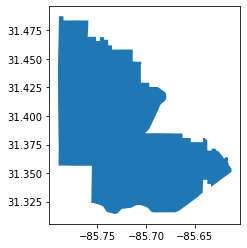

In [40]:
al_precincts[al_precincts['GEOID20']=='010450007-2'].plot()

<AxesSubplot:>

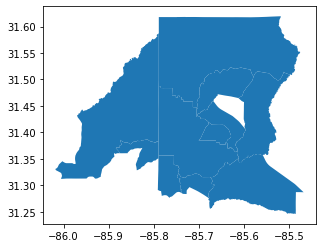

In [38]:
al_tracts_with_precinct[al_tracts_with_precinct['GEOID20_right']=='010450007-2'].plot()

In [43]:
list(al_tracts.keys())

['STATEFP20',
 'COUNTYFP20',
 'TRACTCE20',
 'GEOID20',
 'NAME20',
 'NAMELSAD20',
 'MTFCC20',
 'FUNCSTAT20',
 'ALAND20',
 'AWATER20',
 'INTPTLAT20',
 'INTPTLON20',
 'FILEID',
 'STUSAB',
 'SUMLEV',
 'GEOVAR',
 'GEOCOMP',
 'CHARITER',
 'LOGRECNO',
 'GEOID',
 'GEOCODE',
 'REGION',
 'DIVISION',
 'STATE',
 'STATENS',
 'COUNTY',
 'COUNTYCC',
 'COUNTYNS',
 'TRACT',
 'CBSA',
 'MEMI',
 'CSA',
 'METDIV',
 'AREALAND',
 'AREAWATR',
 'BASENAME',
 'NAME',
 'FUNCSTAT',
 'POP100',
 'HU100',
 'INTPTLAT',
 'INTPTLON',
 'LSADC',
 'P0010001',
 'P0010002',
 'P0010003',
 'P0010004',
 'P0010005',
 'P0010006',
 'P0010007',
 'P0010008',
 'P0010009',
 'P0010010',
 'P0010011',
 'P0010012',
 'P0010013',
 'P0010014',
 'P0010015',
 'P0010016',
 'P0010017',
 'P0010018',
 'P0010019',
 'P0010020',
 'P0010021',
 'P0010022',
 'P0010023',
 'P0010024',
 'P0010025',
 'P0010026',
 'P0010027',
 'P0010028',
 'P0010029',
 'P0010030',
 'P0010031',
 'P0010032',
 'P0010033',
 'P0010034',
 'P0010035',
 'P0010036',
 'P0010037',
 'P0

In [54]:
gdf = gpd.GeoDataFrame(
    al_tracts, geometry=gpd.points_from_xy(al_tracts.INTPTLON20, al_tracts.INTPTLAT20))

<AxesSubplot:>

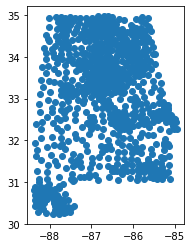

In [55]:
gdf.plot()

In [57]:
al_tracts_with_precinct = gpd.sjoin(gdf, al_precincts[['GEOID20','geometry']], how="inner")

<ipython-input-57-1425dd5c3f83>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  al_tracts_with_precinct = gpd.sjoin(gdf, al_precincts[['GEOID20','geometry']], how="inner")


In [69]:
al_tracts_with_precinct['geometry'] = al_tracts['geometry']

In [68]:
al_tracts.head()

,STATEFP20,COUNTYFP20,TRACTCE20,GEOID20,NAME20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,...,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry
0,01,045,020801,01045020801,208.01,Census Tract,G5020,S,19261326,0,...,17,0,0,17,0,0,0,0,0,"POLYGON ((-85.70064 31.38509, -85.70043 31.385..."
1,01,017,954200,01017954200,9542,Census Tract,G5020,S,62998696,34641,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-85.31549 32.80580, -85.31354 32.808..."
2,01,017,953800,01017953800,9538,Census Tract,G5020,S,515692207,11516898,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-85.59345 33.00012, -85.59333 33.000..."
3,01,017,954300,01017954300,9543,Census Tract,G5020,S,132642536,178276,...,81,0,0,81,0,32,0,0,32,"POLYGON ((-85.38077 32.78301, -85.37985 32.782..."
4,01,017,954700,01017954700,9547,Census Tract,G5020,S,38036820,264376,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-85.22897 32.74543, -85.22894 32.745..."


In [65]:
al_tracts_with_precinct.head()

,STATEFP20,COUNTYFP20,TRACTCE20,GEOID20_left,NAME20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,...,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry,index_right,GEOID20_right
0,01,045,020801,01045020801,208.01,Census Tract,G5020,S,19261326,0,...,0,17,0,0,0,0,0,POINT (-85.66160 31.39714),542,01045000001
266,01,045,020500,01045020500,205,Census Tract,G5020,S,11198907,0,...,0,0,0,21,0,0,21,POINT (-85.61848 31.45111),542,01045000001
267,01,045,020700,01045020700,207,Census Tract,G5020,S,12061262,16200,...,0,0,0,0,0,0,0,POINT (-85.64098 31.44338),542,01045000001
764,01,045,020802,01045020802,208.02,Census Tract,G5020,S,36123008,162711,...,0,114,0,8,0,0,8,POINT (-85.64135 31.41494),542,01045000001
1,01,017,954200,01017954200,9542,Census Tract,G5020,S,62998696,34641,...,0,0,0,0,0,0,0,POINT (-85.26785 32.83414),1961,01017000013


<AxesSubplot:>

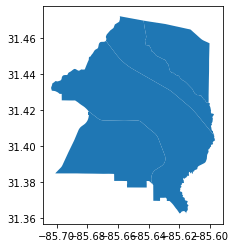

In [70]:
al_tracts_with_precinct[al_tracts_with_precinct['GEOID20_right']=='01045000001'].plot()

<ipython-input-74-0352833671a5>:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  newdf = gpd.overlay(polydf, polydf2, how="union")


<AxesSubplot:>

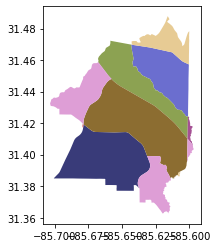

In [74]:
#al_precincts[al_precincts['GEOID20']=='01045000001'].plot()
#al_tracts_with_precinct[al_tracts_with_precinct['GEOID20_right']=='01045000001'].plot(edgecolor='b')
polydf = al_precincts[al_precincts['GEOID20']=='01045000001']
polydf2 = al_tracts_with_precinct[al_tracts_with_precinct['GEOID20_right']=='01045000001']
newdf = gpd.overlay(polydf, polydf2, how="union")
newdf.plot(cmap='tab20b')

C:\Users\robert\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


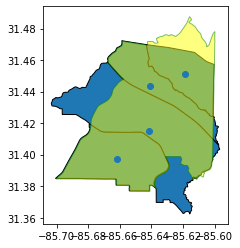

In [87]:
fig, ax = plt.subplots(1)

al_tracts_with_precinct[al_tracts_with_precinct['GEOID20_right']=='01045000001'].plot(edgecolor='black', ax = ax)
al_precincts[al_precincts['GEOID20']=='01045000001'].plot(ax = ax, facecolor = 'yellow', alpha=0.5, edgecolor = 'green')
gdf[al_tracts_with_precinct['GEOID20_right']=='01045000001'].plot(ax = ax)
plt.show()

## Try this with block groups now

In [88]:
al_bg = gpd.read_file('bg/al_pl2020_bg_shp/al_pl2020_bg.shp')

In [89]:
gdf_bg = gpd.GeoDataFrame(
    al_bg, geometry=gpd.points_from_xy(al_bg.INTPTLON20, al_bg.INTPTLAT20))

In [90]:
al_bg_with_precinct = gpd.sjoin(gdf_bg, al_precincts[['GEOID20','geometry']], how="inner")

<ipython-input-90-a5207b3c6f01>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  al_bg_with_precinct = gpd.sjoin(gdf_bg, al_precincts[['GEOID20','geometry']], how="inner")


In [91]:
al_bg = gpd.read_file('bg/al_pl2020_bg_shp/al_pl2020_bg.shp')

C:\Users\robert\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\Users\robert\AppData\Roaming\Python\Python38\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


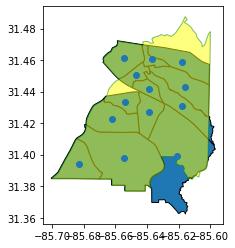

In [94]:
fig, ax = plt.subplots(1)

al_bg[al_bg_with_precinct['GEOID20_right']=='01045000001'].plot(edgecolor='black', ax = ax)
al_precincts[al_precincts['GEOID20']=='01045000001'].plot(ax = ax, facecolor = 'yellow', alpha=0.5, edgecolor = 'green')
gdf_bg[al_bg_with_precinct['GEOID20_right']=='01045000001'].plot(ax = ax)
plt.show()

## With Blocks

In [100]:
al_b = gpd.read_file('block/al_pl2020_b_shp/al_pl2020_p1_b.shp')

In [103]:
import pandas as pd
al_b_csv = pd.read_csv('block_csv/al_pl2020_b_csv/al_pl2020_b.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (29,31,37,38,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [107]:
list(al_b_csv.keys())

['FILEID',
 'STUSAB',
 'SUMLEV',
 'GEOVAR',
 'GEOCOMP',
 'CHARITER',
 'LOGRECNO',
 'GEOID',
 'GEOCODE',
 'REGION',
 'DIVISION',
 'STATE',
 'STATENS',
 'COUNTY',
 'COUNTYCC',
 'COUNTYNS',
 'COUSUB',
 'COUSUBCC',
 'COUSUBNS',
 'CONCIT',
 'CONCITCC',
 'CONCITNS',
 'PLACE',
 'PLACECC',
 'PLACENS',
 'TRACT',
 'BLKGRP',
 'BLOCK',
 'AIANHH',
 'AIHHTLI',
 'AIANHHFP',
 'AIANHHCC',
 'AIANHHNS',
 'AITS',
 'AITSFP',
 'AITSCC',
 'AITSNS',
 'TTRACT',
 'TBLKGRP',
 'ANRC',
 'ANRCCC',
 'ANRCNS',
 'CBSA',
 'MEMI',
 'CSA',
 'METDIV',
 'NECTA',
 'NMEMI',
 'CNECTA',
 'NECTADIV',
 'CBSAPCI',
 'NECTAPCI',
 'CD116',
 'SLDU18',
 'SLDL18',
 'VTD',
 'VTDI',
 'SDELM',
 'SDSEC',
 'SDUNI',
 'AREALAND',
 'AREAWATR',
 'BASENAME',
 'NAME',
 'FUNCSTAT',
 'POP100',
 'HU100',
 'INTPTLAT',
 'INTPTLON',
 'LSADC',
 'UGA',
 'GEOID20',
 'P0010001',
 'P0010002',
 'P0010003',
 'P0010004',
 'P0010005',
 'P0010006',
 'P0010007',
 'P0010008',
 'P0010009',
 'P0010010',
 'P0010011',
 'P0010012',
 'P0010013',
 'P0010014',
 'P0010015'

In [108]:
gdf_b = gpd.GeoDataFrame(
    al_b, geometry=gpd.points_from_xy(al_b_csv.INTPTLON, al_b_csv.INTPTLAT))

In [109]:
al_b_with_precinct = gpd.sjoin(gdf_b, al_precincts[['GEOID20','geometry']], how="inner")

<ipython-input-109-3a5c335d4c10>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  al_b_with_precinct = gpd.sjoin(gdf_b, al_precincts[['GEOID20','geometry']], how="inner")


In [111]:
al_b_with_precinct.head()

,GEOID20_left,SUMLEV,LOGRECNO,GEOID,COUNTY,P0010001,P0010002,P0010003,P0010004,P0010005,...,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,geometry,index_right,GEOID20_right
0,011339655012007,750,0253832,7500000US011339655012007,133,0,0,0,0,0,...,0,0,0,0,0,0,0,POINT (-86.48048 32.47070),372,01001000016
1,011339657003025,750,0254515,7500000US011339657003025,133,15,13,12,0,0,...,0,0,0,0,0,0,0,POINT (-86.48166 32.46817),372,01001000016
2,011339656011006,750,0254104,7500000US011339656011006,133,0,0,0,0,0,...,0,0,0,0,0,0,0,POINT (-86.49166 32.47031),372,01001000016
3,011339659002065,750,0255012,7500000US011339659002065,133,7,7,7,0,0,...,0,0,0,0,0,0,0,POINT (-86.50164 32.47148),372,01001000016
4,010630601022001,750,0133894,7500000US010630601022001,063,7,5,0,5,0,...,0,0,0,0,0,0,0,POINT (-86.50061 32.46761),372,01001000016


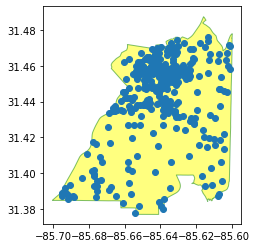

In [113]:
fig, ax = plt.subplots(1)

#al_bg[al_bg_with_precinct['GEOID20_right']=='01045000001'].plot(edgecolor='black', ax = ax)
al_precincts[al_precincts['GEOID20']=='01045000001'].plot(ax = ax, facecolor = 'yellow', alpha=0.5, edgecolor = 'green')
al_b_with_precinct[al_b_with_precinct['GEOID20_right']=='01045000001'].plot(ax = ax)
plt.show()

### Save csv with extra column mapping to the precinct

In [114]:
al_precincts.head()

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREOWRI,G20USSRTUB,...,G20SACRFRI,G20SACOWR2,G20SCCRWIN,G20SCCOWRI,G20SCCRKEL,G20SCCOWR2,G20PSCRCAV,G20PSCDCAS,G20PSCOWRI,geometry
0,01,013,000100,01013000100,Monterey School House,25,37,2,0,25,...,26,1,26,1,25,1,25,35,0,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."
1,01,013,000181,01013000181,Bolling,100,50,0,0,95,...,101,1,101,1,99,1,99,48,0,"POLYGON ((-86.71867 31.73289, -86.71864 31.732..."
2,01,053,000080,01053000080,Rock Hill-Ridge VFD,265,60,3,0,251,...,262,5,259,6,262,4,257,63,0,"POLYGON ((-87.05166 31.11854, -87.04869 31.118..."
3,01,053,000120,01053000120,Damascus-Boykin School,180,143,2,1,172,...,189,2,189,2,189,2,171,145,0,"POLYGON ((-86.95858 31.16635, -86.95844 31.166..."
4,01,053,000100,01053000100,Bradley VFD,68,2,0,0,67,...,70,0,70,0,70,0,69,2,0,"POLYGON ((-86.82985 31.02083, -86.82983 31.020..."


In [115]:
al_precincts[['GEOID20','G20PRERTRU','G20PREDBID','G20PRELJOR']]

,GEOID20,G20PRERTRU,G20PREDBID,G20PRELJOR
0,01013000100,25,37,2
1,01013000181,100,50,0
2,01053000080,265,60,3
3,01053000120,180,143,2
4,01053000100,68,2,0
...,...,...,...,...
1967,01017000006,354,126,4
1968,01017000001,330,90,1
1969,01017000012,278,125,1
1970,01017000010,351,392,7


In [ ]:
import pandas as pd
import geopandas as gpd
    
    
# Read precinct shapefile that has election data
al_precincts = gpd.read_file('election_shp/al_vest_20_shp/al_vest_20.shp')

# Read tract shapefile
al_tracts = gpd.read_file('tract/al_pl2020_t_shp/al_pl2020_t.shp')

# Read block group shape file
al_bg = gpd.read_file('bg/al_pl2020_bg_shp/al_pl2020_bg.shp')

# Read block level csv file (omits the shapes, but as centroid lattitude and longitude)
al_b_csv = pd.read_csv('block_csv/al_pl2020_b_csv/al_pl2020_b.csv')


# Create geopandas dataframe with geometry column as the centroid (that was provided in the csv file)
gdf_b = gpd.GeoDataFrame(
    al_b, geometry=gpd.points_from_xy(al_b_csv.INTPTLON, al_b_csv.INTPTLAT))

# Perform sjoin operation:
## Whenever centroid is in a precinct, label that block with the precint GEOID20 value
al_b_with_precinct = gpd.sjoin(gdf_b, al_precincts[['GEOID20','geometry']], how="inner")

In [196]:
# Disaggregate election data from precincts to blocks

n = len(al_b_with_precinct)

# Create columns for election data 
al_b_with_precinct['R20'] = [0 for _ in range(n)]
al_b_with_precinct['D20'] = [0 for _ in range(n)]
al_b_with_precinct['L20'] = [0 for _ in range(n)]

#Create columns for block group and tract label
al_b_with_precinct['bg'] = [geoid[:-3] for geoid in al_b_with_precinct['GEOID20_left']]
al_b_with_precinct['t'] = [geoid[:-4] for geoid in al_b_with_precinct['GEOID20_left']]

# Loop over all precincts
## This is along operation
for i in al_precincts.index:
    geoid = al_precincts['GEOID20'][i]
    R_votes = al_precincts['G20PRERTRU'][i]
    D_votes = al_precincts['G20PREDBID'][i]
    L_votes = al_precincts['G20PRELJOR'][i]
    #print(R_votes, D_votes, L_votes)
    
    indicies = al_b_with_precinct[al_b_with_precinct['GEOID20_right']==geoid].index
    POP_total = sum(df['P0010001'])
    
    if POP_total > 0:
        for j in indicies:
            ratio = float(df['P0010001'][j]/POP_total)
            #print(df['GEOID20_left'][j], df['P0010001'][j],ratio)
            al_b_with_precinct.loc[j, 'R20'] = R_votes*ratio
            al_b_with_precinct.loc[j, 'D20'] = D_votes*ratio
            al_b_with_precinct.loc[j, 'L20'] = L_votes*ratio
    else:
        for j in indicies:
            #print(df['GEOID20_left'][j], df['P0010001'][j],ratio)
            al_b_with_precinct.loc[j, 'R20'] = 0
            al_b_with_precinct.loc[j, 'D20'] = 0
            al_b_with_precinct.loc[j, 'L20'] = 0 
        

In [212]:
# Aggregate votes from blocks to block groups
al_bg['R20'] = [sum(al_b_with_precinct[al_b_with_precinct['bg']==bg]['R20']) for bg in al_bg['GEOID20']]
al_bg['D20'] = [sum(al_b_with_precinct[al_b_with_precinct['bg']==bg]['D20']) for bg in al_bg['GEOID20']]
al_bg['L20'] = [sum(al_b_with_precinct[al_b_with_precinct['bg']==bg]['L20']) for bg in al_bg['GEOID20']]

In [ ]:
# Distribute votes from blocks to tracts
al_tracts['R20'] = [sum(al_b_with_precinct[al_b_with_precinct['t']==tract]['R20']) for tract in al_tracts['GEOID20']]
al_tracts['D20'] = [sum(al_b_with_precinct[al_b_with_precinct['t']==tract]['D20']) for tract in al_tracts['GEOID20']]
al_tracts['L20'] = [sum(al_b_with_precinct[al_b_with_precinct['t']==tract]['L20']) for tract in al_tracts['GEOID20']]

In [149]:
al_b_with_precinct.to_csv('al_b_with_precinct.csv')

In [170]:
al_b_with_precinct['GEOID20_left'].head()

0    011339655012007
1    011339657003025
2    011339656011006
3    011339659002065
4    010630601022001
Name: GEOID20_left, dtype: object

In [174]:
al_b_with_precinct['bg'] = [geoid[:-3] for geoid in al_b_with_precinct['GEOID20_left']]

In [180]:
al_b_with_precinct['t'] = [geoid[:-4] for geoid in al_b_with_precinct['GEOID20_left']]

In [181]:
al_b_with_precinct

,GEOID20_left,SUMLEV,LOGRECNO,GEOID,COUNTY,P0010001,P0010002,P0010003,P0010004,P0010005,...,P0010070,P0010071,geometry,index_right,GEOID20_right,R20,D20,L20,bg,t
0,011339655012007,750,0253832,7500000US011339655012007,133,0,0,0,0,0,...,0,0,POINT (-86.48048 32.47070),372,01001000016,0.000000,0.000000,0.000000,011339655012,01133965501
1,011339657003025,750,0254515,7500000US011339657003025,133,15,13,12,0,0,...,0,0,POINT (-86.48166 32.46817),372,01001000016,6.285938,2.783868,0.117463,011339657003,01133965700
2,011339656011006,750,0254104,7500000US011339656011006,133,0,0,0,0,0,...,0,0,POINT (-86.49166 32.47031),372,01001000016,0.000000,0.000000,0.000000,011339656011,01133965601
3,011339659002065,750,0255012,7500000US011339659002065,133,7,7,7,0,0,...,0,0,POINT (-86.50164 32.47148),372,01001000016,2.933438,1.299139,0.054816,011339659002,01133965900
4,010630601022001,750,0133894,7500000US010630601022001,063,7,5,0,5,0,...,0,0,POINT (-86.50061 32.46761),372,01001000016,2.933438,1.299139,0.054816,010630601022,01063060102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185912,010890110121009,750,0189481,7500000US010890110121009,089,12,7,5,0,2,...,0,0,POINT (-87.63469 34.07756),592,01133000004,0.803378,0.079614,0.000000,010890110121,01089011012
185918,011270201002008,750,0248749,7500000US011270201002008,127,0,0,0,0,0,...,0,0,POINT (-87.59270 34.07976),592,01133000004,0.000000,0.000000,0.000000,011270201002,01127020100
185972,011290443003049,750,0252992,7500000US011290443003049,129,3,3,2,0,0,...,0,0,POINT (-87.59310 34.08257),592,01133000004,0.200844,0.019903,0.000000,011290443003,01129044300
185973,010610502001013,750,0132055,7500000US010610502001013,061,4,4,4,0,0,...,0,0,POINT (-87.59014 34.07865),592,01133000004,0.267793,0.026538,0.000000,010610502001,01061050200


In [176]:
len('011339655012')

12

In [179]:
len(al_tracts_with_precinct['GEOID20_left'][0])

11

In [197]:
al_tracts_with_precinct['R20'] = [sum(al_b_with_precinct[al_b_with_precinct['t']==tract]['R20']) for tract in al_tracts_with_precinct['GEOID20_left']]
al_tracts_with_precinct['D20'] = [sum(al_b_with_precinct[al_b_with_precinct['t']==tract]['D20']) for tract in al_tracts_with_precinct['GEOID20_left']]
al_tracts_with_precinct['L20'] = [sum(al_b_with_precinct[al_b_with_precinct['t']==tract]['L20']) for tract in al_tracts_with_precinct['GEOID20_left']]

In [198]:
al_tracts_with_precinct[al_tracts_with_precinct['R20'].isna()]

,STATEFP20,COUNTYFP20,TRACTCE20,GEOID20_left,NAME20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,...,P0050007,P0050008,P0050009,P0050010,geometry,index_right,GEOID20_right,R20,D20,L20


In [207]:
a,b,c = sum(al_tracts_with_precinct['R20']), sum(al_tracts_with_precinct['D20']),sum(al_tracts_with_precinct['L20'])
a,b,c

(1441144.364404015, 849617.5751828399, 25175.847087823655)

In [208]:
e,f,g = sum(al_precincts['G20PRERTRU']),sum(al_precincts['G20PREDBID']), sum(al_precincts['G20PRELJOR'])
e,f,g

(1441170, 849624, 25176)

In [209]:
a/e, b/f, c/g

(0.9999822119555744, 0.9999924380465239, 0.9999939262719914)

In [213]:
r,s,t = sum(al_bg['R20']), sum(al_bg['D20']),sum(al_bg['L20'])
r,s,t
r/e,s/f,t/g

(0.999982211955577, 0.999992438046523, 0.9999939262719921)

### Aggregate to blockgroup level
Now with the block data setup, we can aggregate to the block group level


In [168]:
al_b['GEOID20'].head()

0    011339655012007
1    011339657003025
2    011339656011006
3    011339659002065
4    010630601022001
Name: GEOID20, dtype: object

In [167]:
al_bg['GEOID20'].head()

0    010330202001
1    010199560001
2    010730047012
3    010730047021
4    010730047022
Name: GEOID20, dtype: object

In [164]:
a  = al_b['GEOID'][0].split('US')[1]
a, len(a)

('011339655012007', 15)

In [165]:
b = al_bg['GEOID'][0].split('US')[1]
n, len(b)

(185978, 12)

In [166]:
aa = a[:-3]
aa, len(aa)

('011339655012', 12)

# Other code

In [134]:
al_b_with_precinct[al_b_with_precinct['GEOID20_left']=='010419639001076']

,GEOID20_left,SUMLEV,LOGRECNO,GEOID,COUNTY,P0010001,P0010002,P0010003,P0010004,P0010005,...,P0010068,P0010069,P0010070,P0010071,geometry,index_right,GEOID20_right,R20,D20,L20
13447,010419639001076,750,0108013,7500000US010419639001076,041,0,0,0,0,0,...,0,0,0,0,POINT (-86.85465 31.95974),0,01013000100,0,0,0


In [141]:
? df.assign

In [144]:
geoid = al_precincts['GEOID20'][0]
df = al_b_with_precinct[al_b_with_precinct['GEOID20_right']==geoid]
df.to_csv('Example Precinct Distributed to Blocks.csv')

In [145]:
df

,GEOID20_left,SUMLEV,LOGRECNO,GEOID,COUNTY,P0010001,P0010002,P0010003,P0010004,P0010005,...,P0010068,P0010069,P0010070,P0010071,geometry,index_right,GEOID20_right,R20,D20,L20
13447,010419639001076,750,0108013,7500000US010419639001076,041,0,0,0,0,0,...,0,0,0,0,POINT (-86.85465 31.95974),0,01013000100,0.000000,0.000000,0.000000
13448,010419639001077,750,0108014,7500000US010419639001077,041,6,6,6,0,0,...,0,0,0,0,POINT (-86.87356 31.94302),0,01013000100,0.471698,0.698113,0.037736
13449,010419636003049,750,0107539,7500000US010419636003049,041,16,12,12,0,0,...,0,0,0,0,POINT (-86.89541 31.93763),0,01013000100,1.257862,1.861635,0.100629
13450,010059502003042,750,0077324,7500000US010059502003042,005,1,0,0,0,0,...,0,0,0,0,POINT (-86.90812 31.92016),0,01013000100,0.078616,0.116352,0.006289
13452,010150002001024,750,0083577,7500000US010150002001024,015,16,16,2,14,0,...,0,0,0,0,POINT (-86.85521 31.92553),0,01013000100,1.257862,1.861635,0.100629
13455,010730141054008,750,0165786,7500000US010730141054008,073,0,0,0,0,0,...,0,0,0,0,POINT (-86.86250 31.90278),0,01013000100,0.000000,0.000000,0.000000
13456,010730104013024,750,0152256,7500000US010730104013024,073,27,27,0,27,0,...,0,0,0,0,POINT (-86.89519 31.90561),0,01013000100,2.122642,3.141509,0.169811
13457,010730104013016,750,0152248,7500000US010730104013016,073,9,9,0,9,0,...,0,0,0,0,POINT (-86.88190 31.90422),0,01013000100,0.707547,1.047170,0.056604
13458,010730111154023,750,0155923,7500000US010730111154023,073,0,0,0,0,0,...,0,0,0,0,POINT (-86.87615 31.88386),0,01013000100,0.000000,0.000000,0.000000
13459,010730107021071,750,0153123,7500000US010730107021071,073,54,51,45,3,0,...,0,0,0,0,POINT (-86.84667 31.87435),0,01013000100,4.245283,6.283019,0.339623


In [123]:
al_b_with_precinct.keys()

Index(['GEOID20_left', 'SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'P0010001',
       'P0010002', 'P0010003', 'P0010004', 'P0010005', 'P0010006', 'P0010007',
       'P0010008', 'P0010009', 'P0010010', 'P0010011', 'P0010012', 'P0010013',
       'P0010014', 'P0010015', 'P0010016', 'P0010017', 'P0010018', 'P0010019',
       'P0010020', 'P0010021', 'P0010022', 'P0010023', 'P0010024', 'P0010025',
       'P0010026', 'P0010027', 'P0010028', 'P0010029', 'P0010030', 'P0010031',
       'P0010032', 'P0010033', 'P0010034', 'P0010035', 'P0010036', 'P0010037',
       'P0010038', 'P0010039', 'P0010040', 'P0010041', 'P0010042', 'P0010043',
       'P0010044', 'P0010045', 'P0010046', 'P0010047', 'P0010048', 'P0010049',
       'P0010050', 'P0010051', 'P0010052', 'P0010053', 'P0010054', 'P0010055',
       'P0010056', 'P0010057', 'P0010058', 'P0010059', 'P0010060', 'P0010061',
       'P0010062', 'P0010063', 'P0010064', 'P0010065', 'P0010066', 'P0010067',
       'P0010068', 'P0010069', 'P0010070', 'P0010071', 

In [118]:
geoid = '01045000001'
df = al_b_with_precinct[al_b_with_precinct['GEOID20_right']==geoid]

# Disaggregate election data to blocks
We will disaggregate the election data to the blocks.

To do so, calculate the total population in the blocks in a precinct.  

Then for each block, we set 
$$ \text{votes} * \frac{\text{POP}_i}{\text{POP}_{\text{total}}} $$

<AxesSubplot:>

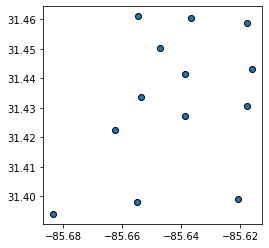

In [93]:
fig, ax = plt.subplots(1)

al_bg_with_precinct[al_bg_with_precinct['GEOID20_right']=='01045000001'].plot(edgecolor='black', ax = ax)

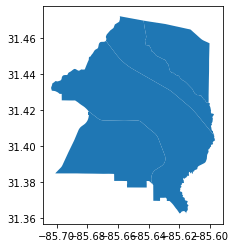

In [76]:
ax = al_tracts_with_precinct[al_tracts_with_precinct['GEOID20_right']=='01045000001'].plot()

In [79]:
import contextily as ctx
ctx.add_basemap(ax)

ModuleNotFoundError: No module named 'contextily'

In [80]:
conda install contextily --channel conda-forge

^C

Note: you may need to restart the kernel to use updated packages.


In [ ]:
cities_with_country = geopandas.sjoin(cities, countries, how="inner", op='intersects')

In [47]:
import matplotlib.pyplot as plt

<AxesSubplot:>

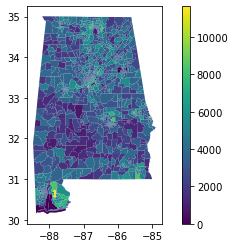

In [48]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)

al_tracts.plot(column='POP100', ax=ax, legend=True, cax=cax)